## Load All Required Libraries

In [1]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import itertools
from imblearn import over_sampling

#To Try different various hyptermeters
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.model_selection import GridSearchCV

#Algo to use for modelling
from sklearn.linear_model import LogisticRegression
import lightgbm as lgbm
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,  GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron

#To Mearure Performance of Model
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import  sklearn.metrics as metrics

run_cv=False 
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
pd.set_option("display.max_columns",100)

## Variables Used in the program

In [4]:
#paths required
datafolder_p  = r'D:\18-DS\github\SDSHL\data\processed'
datafolder_e  = r'D:\18-DS\github\SDSHL\data\external'
datafolder_i  = r'D:\18-DS\github\SDSHL\data\internal'
modelfolder   = r'D:\18-DS\data\models'
resultsfolder = r'D:\18-DS\github\SDSHL\data\results'

file_train = datafolder_p + r'\2-train.csv'
file_test  = datafolder_p + r'\2-test.csv'
file_org   = datafolder_p + r'\1-Hinglish_SarcasmCSV.csv'
file_FE    = datafolder_p + r'\4-Hinglish_Sarcasm_Clean_FE'



embed_name={
1: 'TFIDF'             ,
2: 'Word2Vec'          ,
3: 'BOW'               ,
4: 'IndicBERT'         ,
5: 'mBERT'             ,
6: 'fastText'          ,
7: 'IndicFT'           ,
8: 'fastTextWiki'      ,
9: 'Lexical'           
}

#These file names without end train & test and .csv (extention)
embed_file={
'TFIDF'            : r'\embedding_tfidf.csv',
'Word2Vec'         : r'\embedding_w2v.csv',
'BOW'              : r'\embedding_bow.csv',
'IndicBERT'        : r'\embedding_bert768_indicbert_pretrained.csv',
'mBERT'            : r'\embedding_bert768_mbert_pretrained.csv',
'fastText'         : r'\embedding_ft_local.csv',
'IndicFT'          : r'\embedding_ft300_indicft_pretrained.csv',
'fastTextWiki'     : r'\embedding_ft300_wiki_pretrained.csv',
'Lexical'          : r'\4-Hinglish_Sarcasm_Clean_FE.csv'   
}

#All Prediction Results  of different models with different embedding are saved in this dict
prediction={}

print ("Number of embeddings used :" , len(embed_file))

print ("10 Classifiers Experiments are : LR, LGBM, NB, SVC, ADB, GBC, RFC, XGB, DT, Perceptron")

Number of embeddings used : 9
10 Classifiers Experiments are : LR, LGBM, NB, SVC, ADB, GBC, RFC, XGB, DT, Perceptron


## Create Train Test Split Dataset for different Embedding

In [5]:
#When we want to use different data balancing tacheck we can use option variable below
model_with_data_list=['Normal','RandomOverSampler','Smote','AdaSyn']
option = 0 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<  Change this to chose different different data balancing Technqiue

def read_embedding_data(embed_number):
    #embed_number=3 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Change this
    print (embed_name[embed_number])

    file_data = datafolder_p +  embed_file[ embed_name[embed_number] ]
    df = pd.read_csv(file_data, index_col="ID")

    #This strategy of test train split is taken to ensure that all embedding has same set of records
    df_train =  pd.read_csv(file_train, index_col="ID", sep='\t')
    df_test  =  pd.read_csv(file_test, index_col="ID", sep='\t')
    idx_train = list(df_train.index)
    idx_test  = list(df_test.index)

    X_train = df.loc[ idx_train,]
    X_val  = df.loc[ idx_test,]

    y_train1 = X_train['label']
    y_val1   = X_val['label']
    X_train1 = X_train.drop(columns=['label'])
    X_val1  = X_val.drop(columns=['label'])

    print( X_train1.shape, X_val1.shape, y_train1.shape, y_val1.shape)

    ##########################################################################################3
    #Data Imbalance - Over Sampling    

    if option==0:
        X_train, X_val, y_train, y_val = X_train1, X_val1, y_train1, y_val1

    elif option==1:
        ros = over_sampling.RandomOverSampler(random_state=100)
        X_train_ros, y_train_ros       = ros.fit_resample(X_train1, y_train1)

        X_train, X_val, y_train, y_val = X_train_ros, X_val1, y_train_ros , y_val1

    elif option==2:
        smt = over_sampling.SMOTE(random_state=100)
        X_train_smote, y_train_smote   = smt.fit_resample(X_train1, y_train1)

        X_train, X_val, y_train, y_val = X_train_smote, X_val1, y_train_smote , y_val1

    elif option==3:
        ada = over_sampling.ADASYN(random_state=100)
        X_train_adasyn, y_train_adasyn = ada.fit_resample(X_train1, y_train1)

        X_train, X_val, y_train, y_val = X_train_adasyn, X_val1, y_train_adasyn , y_val1


    print ( 'Oversampling Technique Used:' + model_with_data_list[option])
    print( X_train.shape, X_val.shape, y_train.shape, y_val.shape)
    return X_train,X_val, y_train, y_val

## Common Functions Used in this Project

In [6]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Plotting cv results
def draw_cv_results(cv_df, param_name, metric_name, title_name, log_true):
    plt.figure(figsize=(10,4))
    
    if log_true:
        x_axis= np.log10( list(cv_df[param_name]))
        x_axis_title = "Log Value "+param_name
    else:
        x_axis = list(cv_df[param_name])
        x_axis_title = param_name
        
    plt.plot( x_axis, cv_df['mean_train_score'] )
    plt.plot( x_axis, cv_df['mean_test_score'] )
    plt.xlabel(x_axis_title)
    plt.ylabel(metric_name)
    plt.title(title_name)
    plt.legend(['Train ' + metric_name +' score', 'Test ' +metric_name+' score'], loc='upper left')

    
# Function to plot the confusion Matrix
def draw_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.tab10):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
   
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = 'd' 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.fill(j,i,facecolor="red" if cm[i, j] < thresh else "blue", edgecolor='b', linewidth=2)
        #plt.Rectangle((0, 0), 1, 0, linewidth=1, edgecolor='b', facecolor='none')
        
        plt.text(j, i, format(cm[i, j], fmt), fontsize=20, weight="bold", 
                 verticalalignment='center',
                 horizontalalignment="center",
                 color="white", 
                 
                bbox=dict(facecolor='red', alpha=0.8))

    plt.tight_layout()
    plt.ylabel('True label',fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    

class_names=[0,1]

def draw_roc( actual, probs, prob_values=True, Threshold_limit=0.4, pred_colname='Unknown' ):
  
    print (pred_colname)
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                          drop_intermediate = False )
    
    threshold = thresholds[np.argmax(tpr-fpr)]

    if prob_values:
        pred= probs.map(lambda x: 1 if x > threshold else 0)
    else:
        pred= probs
    
    prediction[ pred_colname ] = probs
    
    auc_score = round( metrics.roc_auc_score( actual, probs) ,2)
    
    recall    = round( metrics.recall_score(actual,pred),2)
    precision = round(metrics.precision_score(actual, pred),2)
    accuracy  = round(metrics.accuracy_score(actual,pred),2)
    f1= round(metrics.f1_score(actual,pred),2)
    

    plt.figure(figsize=(20, 5))
    plt.subplot(1,2,1)
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]',fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('Receiver operating characteristic example',fontsize=20)
    plt.legend(loc="lower right")
    
    plt.subplot(1,2,2)
    cm = confusion_matrix(actual, pred)
    draw_confusion_matrix(cm,class_names)
    plt.show()
    
    print ("This Model Result is for ", model_with_data_list[option], " Data")
    print ("ROC AUC Score on Test:",auc_score," Threshold:{:.5f}".format(threshold))
    print ("Accuracy",accuracy,"AUC:",auc_score,"Recall:",recall,"Precision:",precision,"F1:",f1)
    return accuracy,auc_score,recall,precision,f1

# Use Cross Validation to optimize Hypermeters
### It takes too much time so be careful when you run it.

In [7]:
#LR, LGBM, NB, SVC, ADB, GBC, RFC, XGB, DT, Perceptron
def process_cv_model(modelname):
    if modelname=="LR":
        hyper_params= [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }]
        model = LogisticRegression(max_iter=1000, random_state=100)
        
    elif modelname=="LGBM":
        hyper_params= [{  'n_estimators': range(10,110,10)  }]
        model = lgbm.LGBMClassifier(random_state=100)
        
    elif modelname=="GBC":
        hyper_params=[{  'n_estimators': range(10,110,10)  }]
        model = GradientBoostingClassifier(random_state=100)
        
    elif modelname=="RFC":
        hyper_params=[{  'n_estimators': [100,300,500,800,1200], 'max_depth':[5,10,15,20],\
                       'min_samples_split': [2, 5, 10, 15], 'min_samples_leaf':[1, 2, 5, 10]   }]
        model = RandomForestClassifier(random_state=100)
   
    elif modelname=="XGB":
        hyper_params=[{  'n_estimators': [10, 100,200, 500, 1000], 'subsample':[1,2,3] }]
        model = XGBClassifier(tree_method='hist',colsample_level=0.06, verbose=0,
                    n_jobs=6, random_state=100)
    
    elif modelname=="DT":
        hyper_params= [{'max_depth': [2,3,5,10,12,14], 'max_features': [5,7,9,11,15]}]            
        model = DecisionTreeClassifier(random_state = 100, criterion='entropy')

    model_cv = GridSearchCV(estimator=model, param_grid=hyper_params, \
                            cv=folds, scoring="f1", return_train_score=True, verbose=False)
    model_cv.fit(X_train,  y_train)

    return model_cv

In [ ]:
#Try Cross Valdiation with This Embedding 
embed_number=8
X_train,X_val, y_train, y_val = read_embedding_data(embed_number)
#print ("Embedding Name:",embed_name[embed_number])

In [ ]:
#model_cv = process_cv_model("RFC")
# cv_results = pd.DataFrame(model_cv.cv_results_)
# print (model_cv.best_params_)
# print ("Cross Validators Created {} models".format(len(cv_results)))
# cv_results.sort_values('rank_test_score').head(5)

In [ ]:
#cv_results.to_csv(resultsfolder + r'\CVresults_RFC.csv')

In [ ]:
#if you want draw results of CV against the some hypermeter then you can enter paramerter name and plot
#draw_cv_results(cv_results, 'param_n_estimators', 'F1 Score', 'Max Feature', True)

## All the Modles Used in the Program. Parameters are set after performing CV

In [8]:
def process_model_LR(pred_colname):
    #Hyperparamter Tuning
    lr = LogisticRegression(C=.01,max_iter=1000, random_state=100)

    lr.fit(X_train,y_train)

    y_val_pred_logistic = lr.predict_proba(X_val)
    y_val_pred_logistic = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_logistic[:,1:2].reshape(-1) })

    #check ROC_AUC Score on Test
    logistic_acc, logistic_auc_val, logistic_recall_val, logistic_precision_val, logistic_f1_val = \
                            draw_roc(y_val_pred_logistic.Class, y_val_pred_logistic.Class_Prob, True, 0.6, pred_colname)
    
    
def process_model_LGBM(pred_colname):
    #Hyperparamter Tuning
    lgbmc = lgbm.LGBMClassifier(n_estimators=90, random_state = 100)
#     lgbmc = lgbm.LGBMClassifier(colsample_bytree=1.0,
#                    importance_type='split', learning_rate=0.1, max_depth=-1,
#                    min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                    n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
#                    random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#                    subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

    lgbmc.fit(X_train, y_train) 

    y_val_pred_lgbmc = lgbmc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_lgbmc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_lgbmc  }) #.reshape(-1)

    lgbmc_accuracy_val, lgbmc_auc_val, lgbmc_recall_val, lgbmc_precision_val, lgbmc_f1_val = \
                            draw_roc(y_val_pred_lgbmc.Class, y_val_pred_lgbmc.Class_Prob,True,.6,pred_colname)
    
def process_model_NB(pred_colname):
    nb = GaussianNB()

    nb.fit(X_train, y_train) 

    y_val_pred_nb = nb.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_nb = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_nb  }) #.reshape(-1)

    nb_accuracy_val, nb_auc_val, nb_recall_val, nb_precision_val, nb_f1_val = \
                            draw_roc(y_val_pred_nb.Class, y_val_pred_nb.Class_Prob,True,.6,pred_colname)
    
def process_model_GBC(pred_colname):
    #Hyperparamter Tuning
    gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                               learning_rate=0.1, loss='deviance', max_depth=3,
                               max_features=None, max_leaf_nodes=None,
                               min_impurity_decrease=0.0, min_impurity_split=None,
                               min_samples_leaf=1, min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=100,
                               n_iter_no_change=None, presort='deprecated',
                               random_state=100, subsample=1.0, tol=0.0001,
                               validation_fraction=0.1, verbose=0,
                               warm_start=False)

    gbc.fit(X_train, y_train) 

    y_val_pred_gbc = gbc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_gbc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_gbc  }) #.reshape(-1)

    gbc_accuracy_val, gbc_auc_val, gbc_recall_val, gbc_precision_val, gbc_f1_val = \
                            draw_roc(y_val_pred_gbc.Class, y_val_pred_gbc.Class_Prob,True, .6, pred_colname)
    
    
def process_model_RFC(pred_colname):
    #Hyperparamter Tuning 
    rfc = RandomForestClassifier( max_depth=10, min_samples_leaf= 2, min_samples_split= 2,\
                                 n_estimators= 800, random_state=100)
    rfc.fit(X_train, y_train) 

    y_val_pred_rfc = rfc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_rfc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_rfc  }) #.reshape(-1)

    rfc_accuracy_val, rfc_auc_val, rfc_recall_val, rfc_precision_val, rfc_f1_val = \
                            draw_roc(y_val_pred_rfc.Class, y_val_pred_rfc.Class_Prob,True,.6, pred_colname)
    
def process_model_ADB(pred_colname):
    adbc = AdaBoostClassifier( random_state=100)
    adbc.fit(X_train, y_train) 

    y_val_pred_adbc = adbc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_adbc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_adbc  }) #.reshape(-1)

    adbc_accuracy_val, adbc_auc_val, adbc_recall_val, adbc_precision_val, adbc_f1_val = \
                            draw_roc(y_val_pred_adbc.Class, y_val_pred_adbc.Class_Prob,True,.6,pred_colname)
    
def process_model_SVC(pred_colname):
    svc = SVC( random_state=100, probability=True)
    svc.fit(X_train, y_train) 

    y_val_pred_svc = svc.predict_proba(X_val)[:,1:2].reshape(-1)
    y_val_pred_svc = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_svc  }) #.reshape(-1)

    svc_accuracy_val, svc_auc_val, svc_recall_val, svc_precision_val, svc_f1_val = \
                            draw_roc(y_val_pred_svc.Class, y_val_pred_svc.Class_Prob,True, .6, pred_colname)


def process_model_XGB(pred_colname):
    #Hyperparamter Tuning
    xgb = XGBClassifier(n_estimators=5000,
                    tree_method='hist',
                    subsample=1,
                    colsample_level=0.06,
                    verbose=0,
                    n_jobs=6,
                    random_state=100)

    xgb.fit(X_train, y_train) 

    y_val_pred_xgb = xgb.predict_proba(X_val)[:,1:2].reshape(-1)

    y_val_pred_xgb = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_xgb  }) #.reshape(-1)

    xgb_accuracy_val, xgb_auc_val, xgb_recall_val, xgb_precision_val, xgb_f1_val = \
                            draw_roc(y_val_pred_xgb.Class, y_val_pred_xgb.Class_Prob,True,.6,pred_colname)

def process_mode_DT(pred_colname):
    #Hyperparamter Tuning
    dt = DecisionTreeClassifier(criterion = 'entropy', max_depth= 10, max_features= 9, random_state = 100)
    
    dt.fit(X_train, y_train) 

    y_val_pred_dt = dt.predict_proba(X_val)[:,1:2].reshape(-1)

    y_val_pred_dt = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_dt  }) #.reshape(-1)

    dt_accuracy_val, dt_auc_val, dt_recall_val, dt_precision_val, dt_f1_val = \
                            draw_roc(y_val_pred_dt.Class, y_val_pred_dt.Class_Prob,True,.6,pred_colname)

def process_model_Perceptron(pred_colname):
    perceptron = Perceptron(random_state=100)
    perceptron.fit(X_train, y_train)
    
    y_val_pred_perceptron = perceptron.predict(X_val)
    y_val_pred_perceptron = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_perceptron  }) #.reshape(-1)

    perceptron_accuracy_val, perceptron_auc_val, perceptron_recall_val, perceptron_precision_val, perceptron_f1_val = \
                            draw_roc(y_val_pred_perceptron.Class, y_val_pred_perceptron.Class_Prob,False, .6, pred_colname)
    
    
# def process_model_LexicalLGBMC(pred_colname):
#     #Hyperparamter Tuning
#     lgbmc_FE = lgbm.LGBMClassifier(colsample_bytree=1.0,
#                    importance_type='split', learning_rate=0.1, max_depth=-1,
#                    min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
#                    n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
#                    random_state=100, reg_alpha=0.0, reg_lambda=0.0, silent=True,
#                    subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#     lgbmc_FE.fit(X_train, y_train) 

#     y_val_pred_lgbmcFE = lgbmc_FE.predict_proba(X_val)[:,1:2].reshape(-1)

#     y_val_pred_lgbmcFE = pd.DataFrame({'Class':y_val.values, 'Class_Prob':y_val_pred_lgbmcFE  }) #.reshape(-1)

#     lgbmcFE_accuracy_val, lgbmcFE_auc_val, lgbmcFE_recall_val, lgbmcFE_precision_val, lgbmcFE_f1_val = \
#                             draw_roc(y_val_pred_lgbmcFE.Class, y_val_pred_lgbmcFE.Class_Prob,True,.6,pred_colname)
    


## Fit the model. Predict Results. Call all the 8 models with 8 Embedding

In [ ]:
#1: 'TFIDF', 2: 'Word2Vec', 3: 'BOW' ,4: 'IndicBERT', 5: 'mBERT', 6: 'fastText', 7: 'IndicFT', 8: 'fastTextWiki',\
#9: 'Lexical'

TFIDF
(1800, 200) (200, 200) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 200) (200, 200) (1800,) (200,)
TFIDF_LR


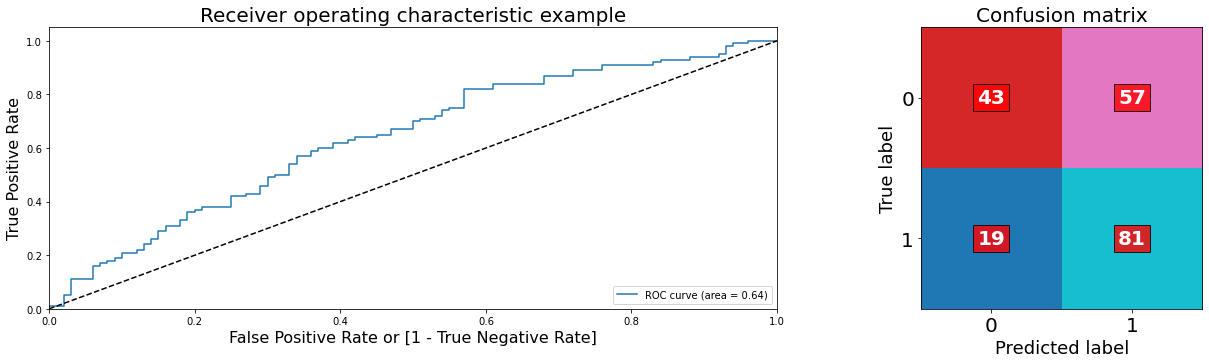

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.49622
Accuracy 0.62 AUC: 0.64 Recall: 0.81 Precision: 0.59 F1: 0.68
TFIDF_LGBM


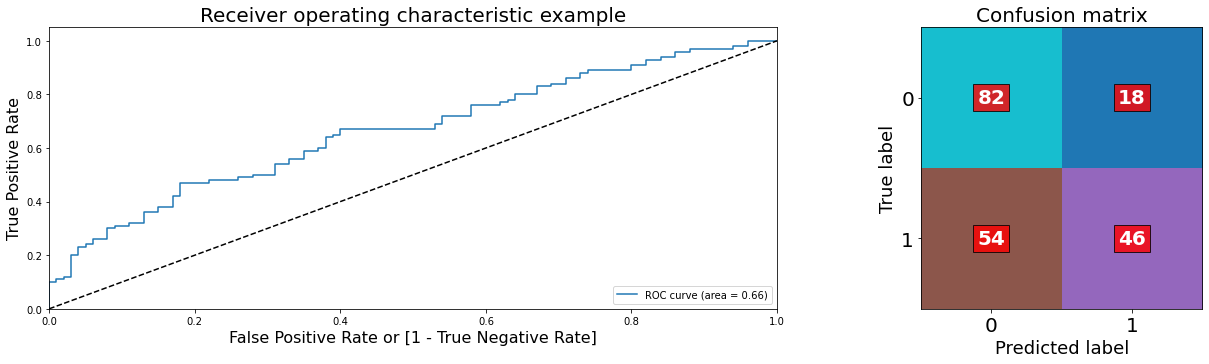

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.59259
Accuracy 0.64 AUC: 0.66 Recall: 0.46 Precision: 0.72 F1: 0.56
TFIDF_NB


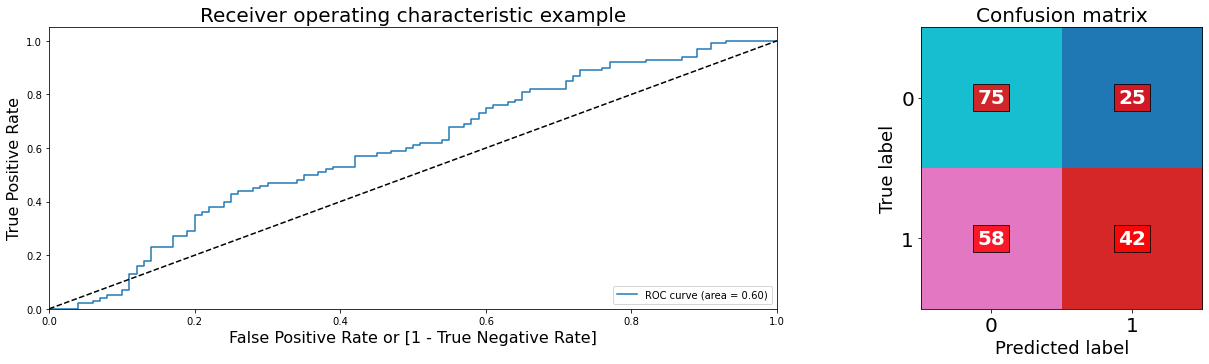

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:0.73708
Accuracy 0.58 AUC: 0.6 Recall: 0.42 Precision: 0.63 F1: 0.5
TFIDF_SVC


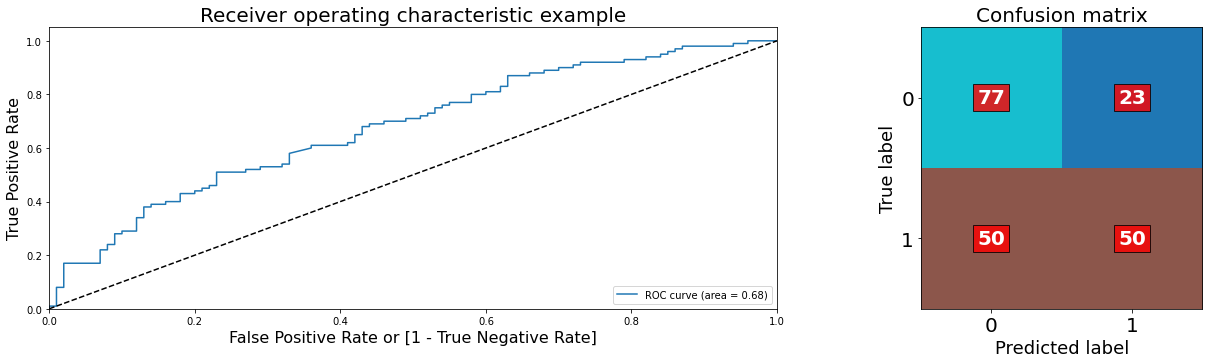

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.52758
Accuracy 0.64 AUC: 0.68 Recall: 0.5 Precision: 0.68 F1: 0.58
TFIDF_ADB


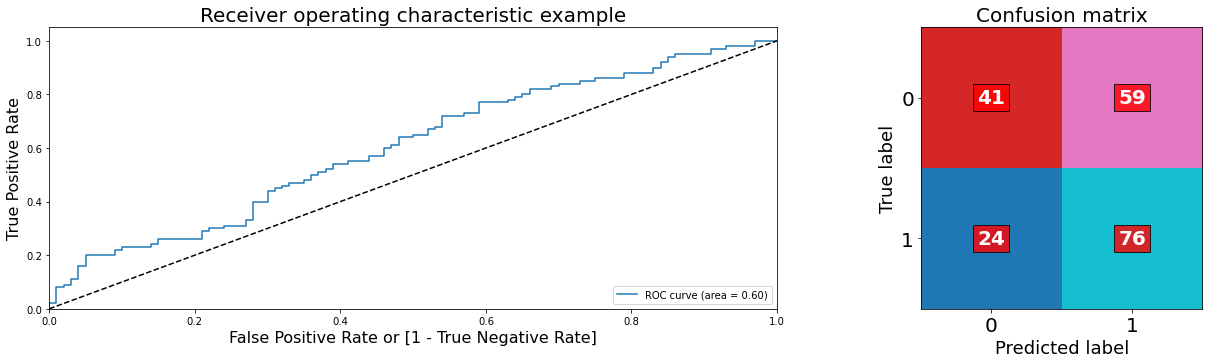

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:0.49717
Accuracy 0.58 AUC: 0.6 Recall: 0.76 Precision: 0.56 F1: 0.65
TFIDF_GBC


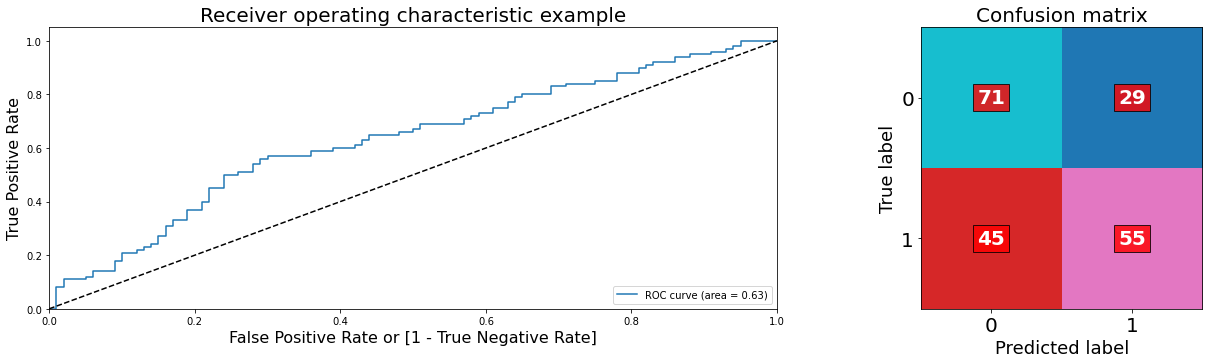

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.50941
Accuracy 0.63 AUC: 0.63 Recall: 0.55 Precision: 0.65 F1: 0.6
TFIDF_RFC


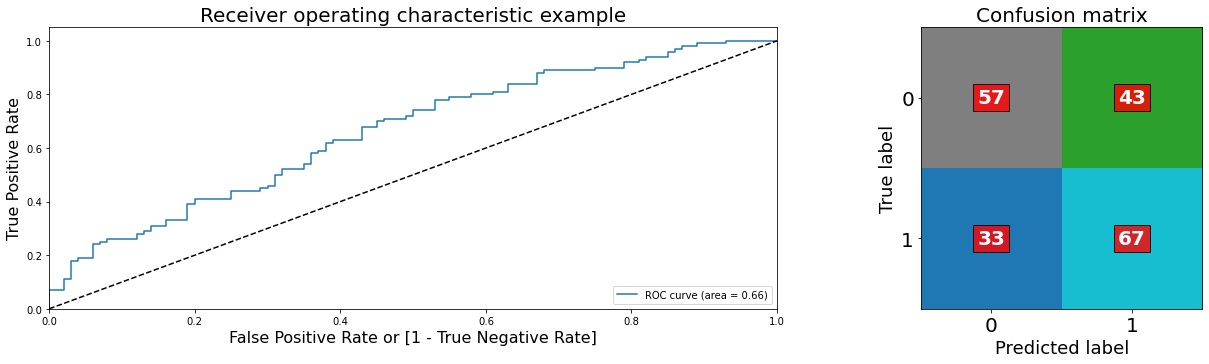

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.49093
Accuracy 0.62 AUC: 0.66 Recall: 0.67 Precision: 0.61 F1: 0.64
[14:36:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


TFIDF_XGB


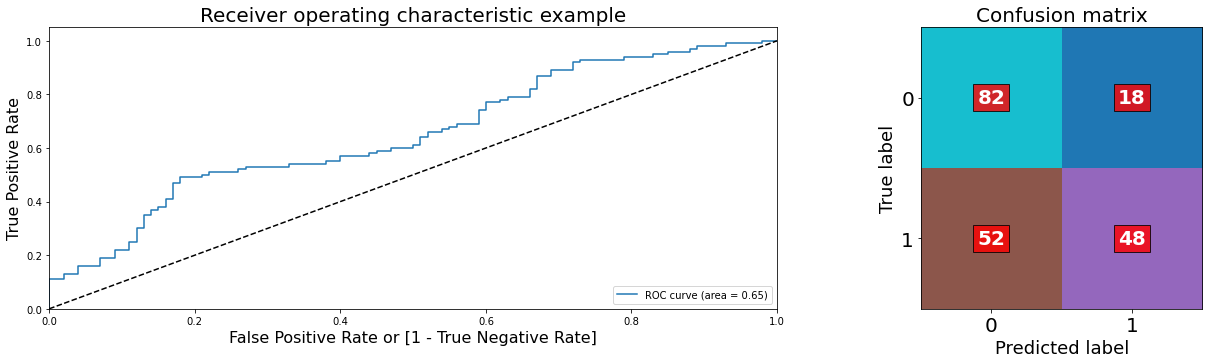

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.65  Threshold:0.79976
Accuracy 0.65 AUC: 0.65 Recall: 0.48 Precision: 0.73 F1: 0.58
TFIDF_DT


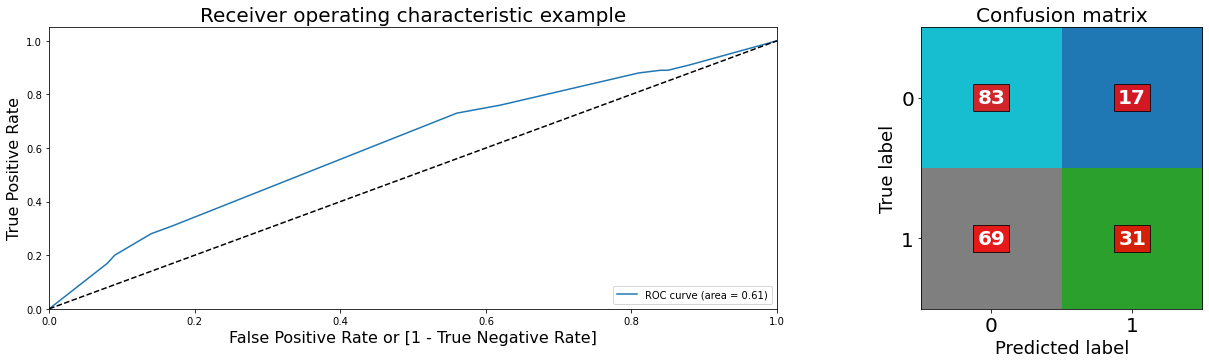

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.58696
Accuracy 0.57 AUC: 0.61 Recall: 0.31 Precision: 0.65 F1: 0.42
TFIDF_Perceptron


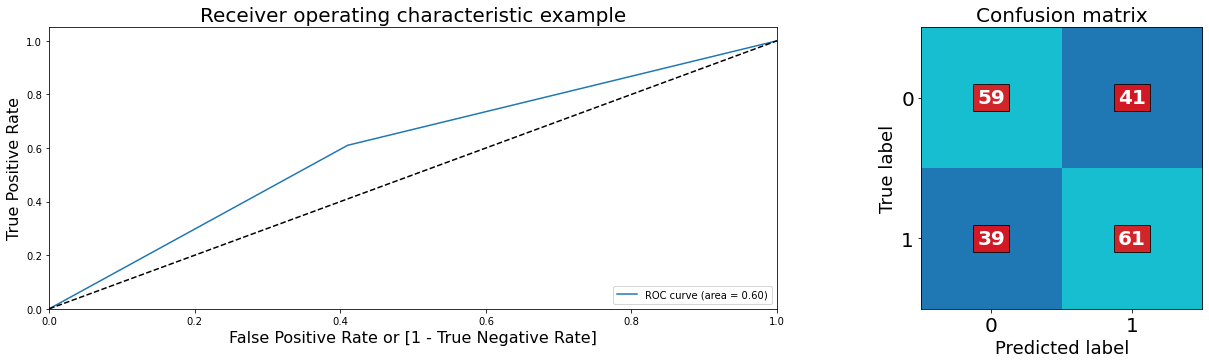

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:1.00000
Accuracy 0.6 AUC: 0.6 Recall: 0.61 Precision: 0.6 F1: 0.6
Word2Vec
(1800, 50) (200, 50) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 50) (200, 50) (1800,) (200,)
Word2Vec_LR


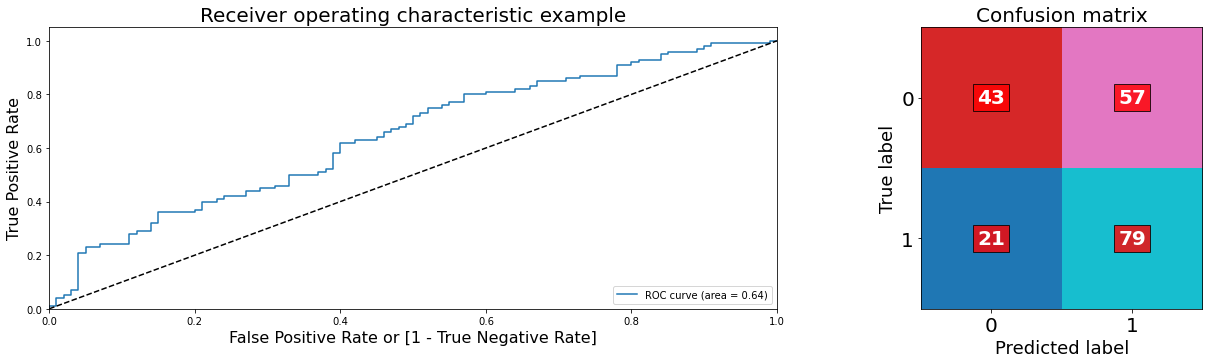

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.49411
Accuracy 0.61 AUC: 0.64 Recall: 0.79 Precision: 0.58 F1: 0.67
Word2Vec_LGBM


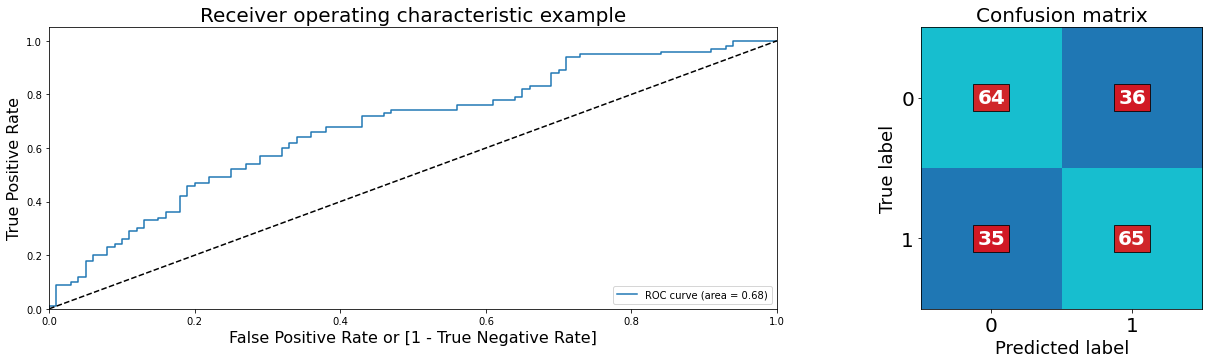

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.56005
Accuracy 0.64 AUC: 0.68 Recall: 0.65 Precision: 0.64 F1: 0.65
Word2Vec_NB


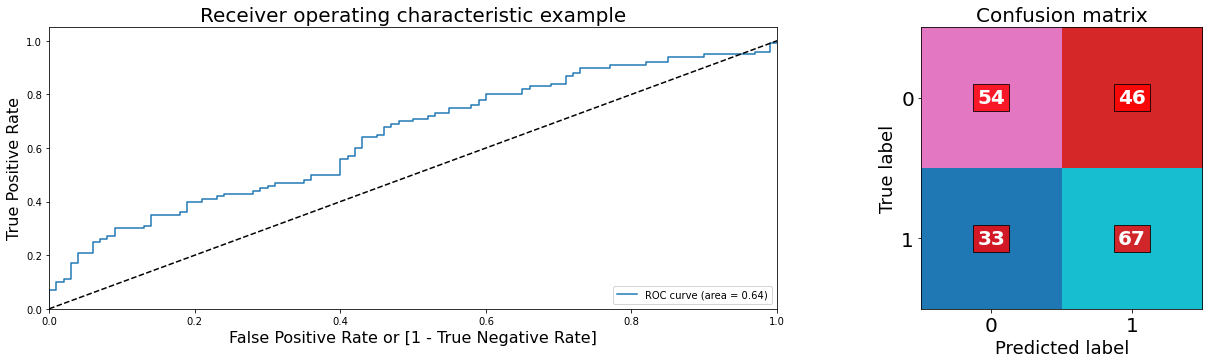

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.96519
Accuracy 0.6 AUC: 0.64 Recall: 0.67 Precision: 0.59 F1: 0.63
Word2Vec_SVC


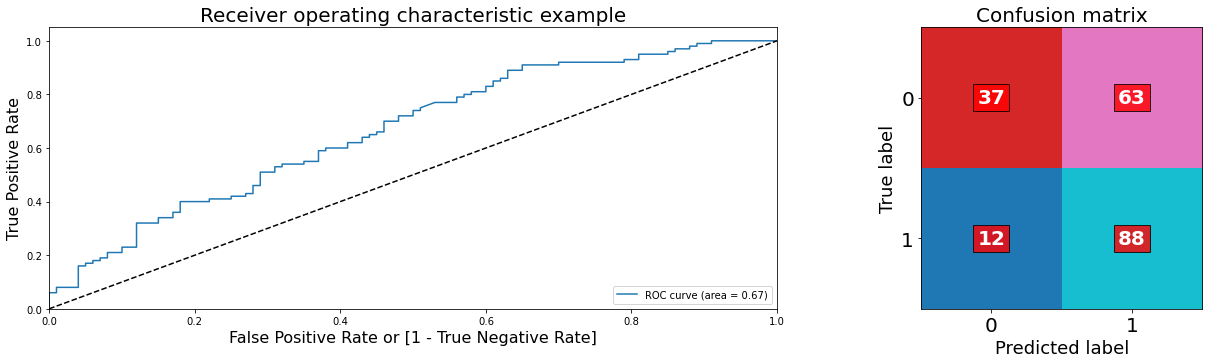

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.67  Threshold:0.44233
Accuracy 0.62 AUC: 0.67 Recall: 0.88 Precision: 0.58 F1: 0.7
Word2Vec_ADB


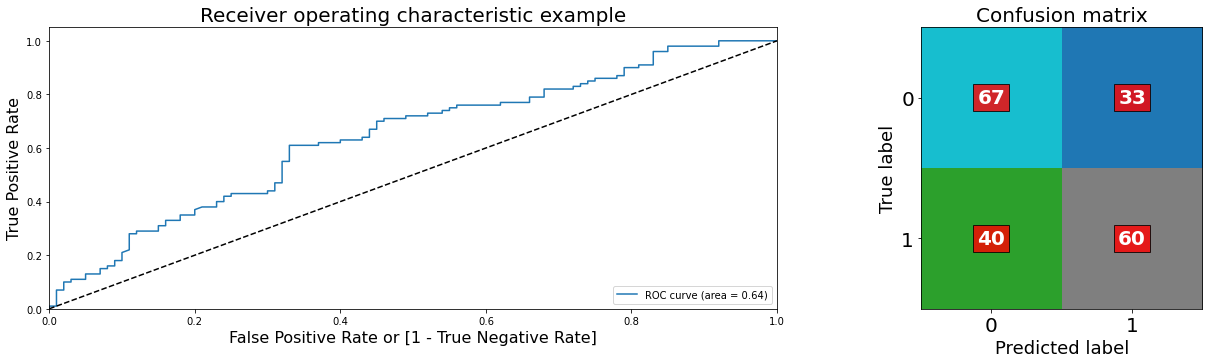

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.50153
Accuracy 0.64 AUC: 0.64 Recall: 0.6 Precision: 0.65 F1: 0.62
Word2Vec_GBC


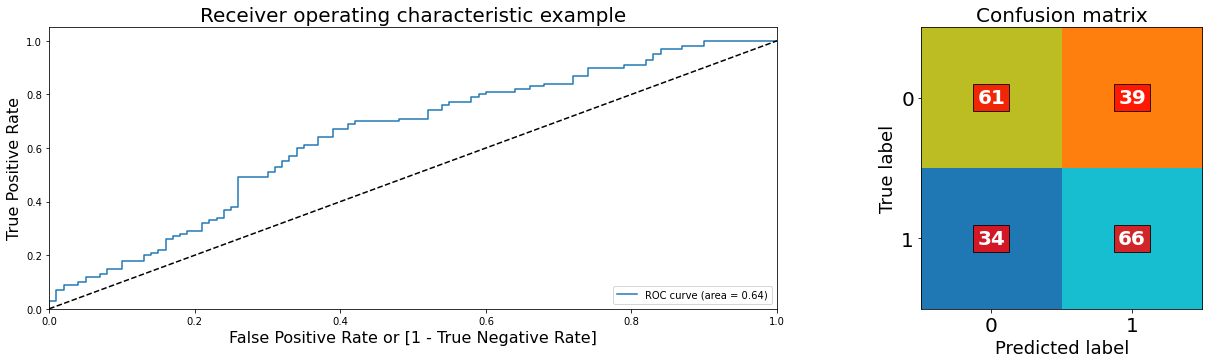

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.52028
Accuracy 0.64 AUC: 0.64 Recall: 0.66 Precision: 0.63 F1: 0.64
Word2Vec_RFC


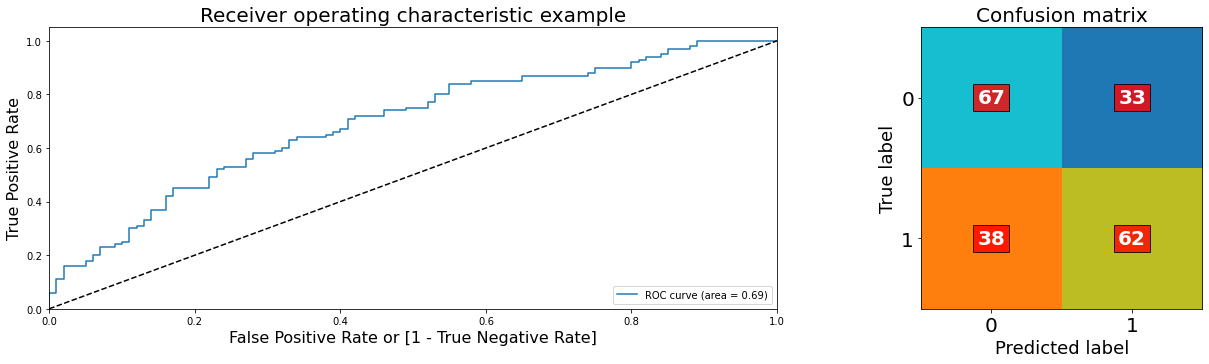

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.59354
Accuracy 0.64 AUC: 0.69 Recall: 0.62 Precision: 0.65 F1: 0.64
[14:37:00] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Word2Vec_XGB


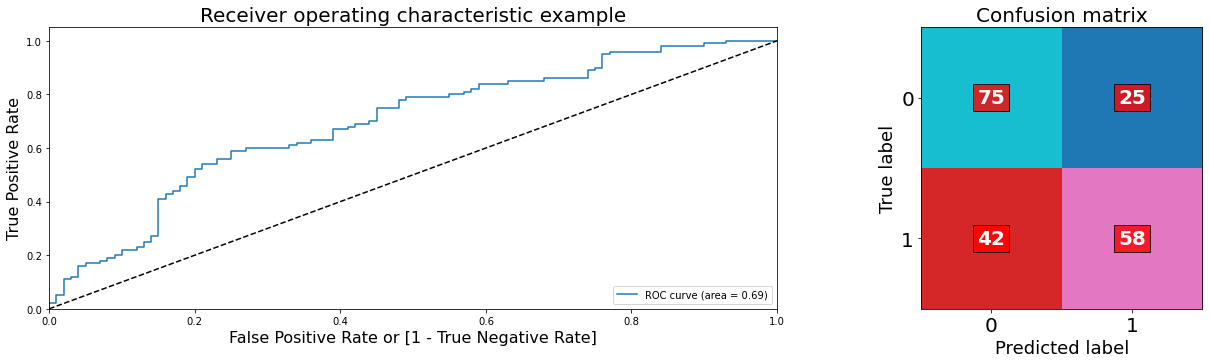

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.74356
Accuracy 0.66 AUC: 0.69 Recall: 0.58 Precision: 0.7 F1: 0.63
Word2Vec_DT


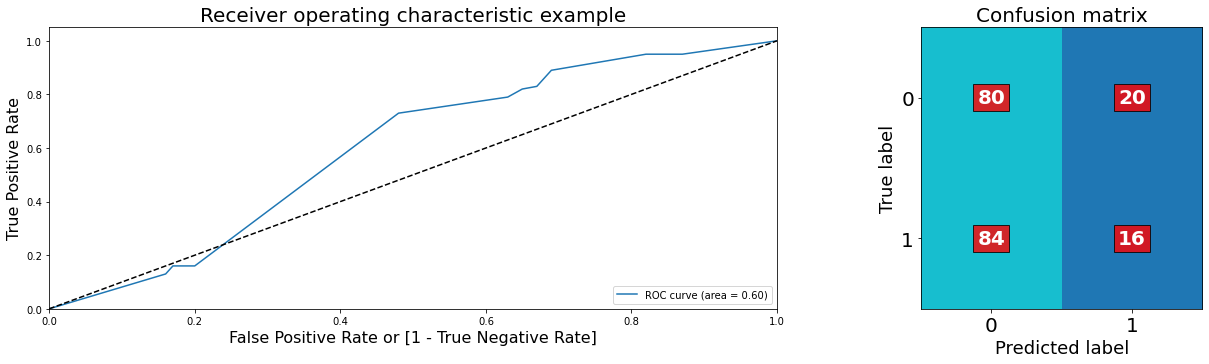

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:0.58577
Accuracy 0.48 AUC: 0.6 Recall: 0.16 Precision: 0.44 F1: 0.24
Word2Vec_Perceptron


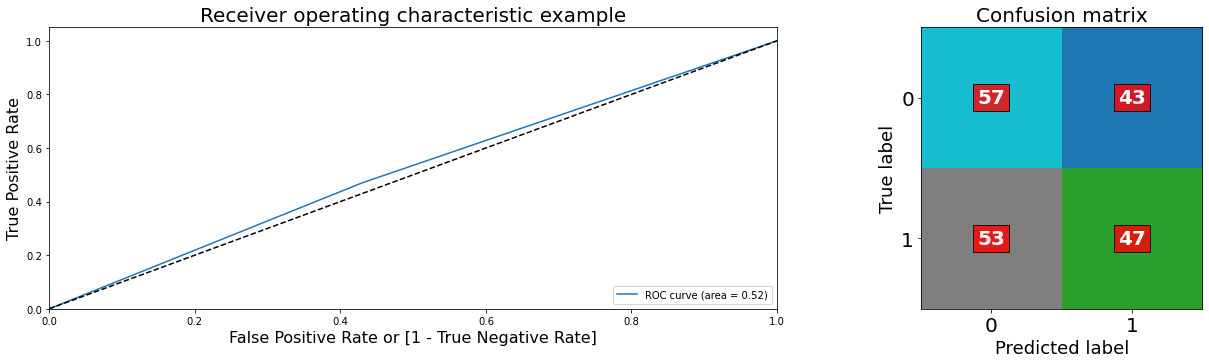

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.52  Threshold:1.00000
Accuracy 0.52 AUC: 0.52 Recall: 0.47 Precision: 0.52 F1: 0.49
BOW
(1800, 200) (200, 200) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 200) (200, 200) (1800,) (200,)
BOW_LR


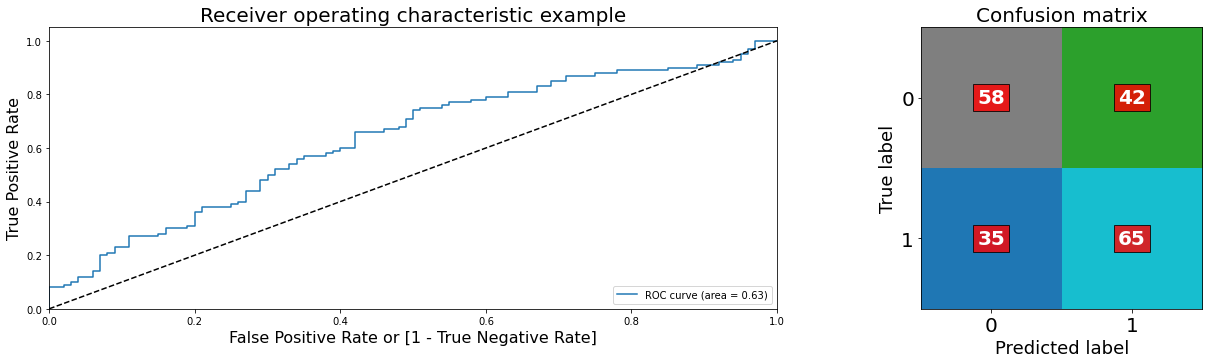

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.48693
Accuracy 0.62 AUC: 0.63 Recall: 0.65 Precision: 0.61 F1: 0.63
BOW_LGBM


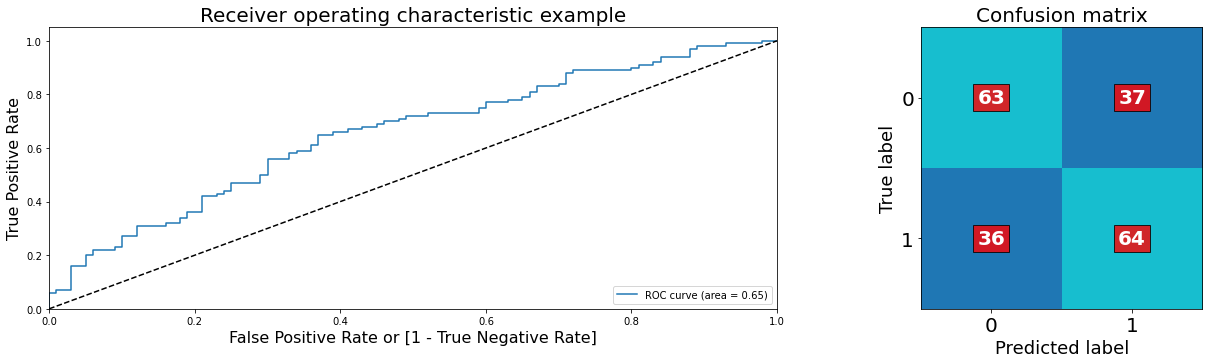

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.65  Threshold:0.44605
Accuracy 0.64 AUC: 0.65 Recall: 0.64 Precision: 0.63 F1: 0.64
BOW_NB


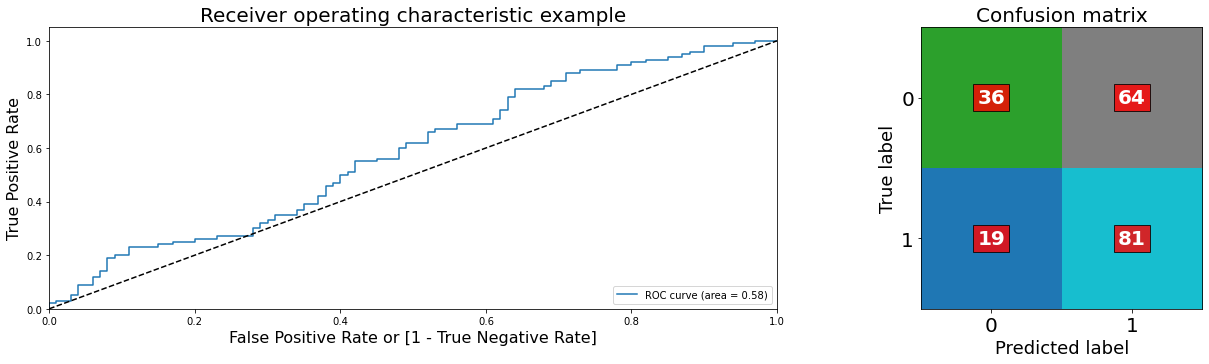

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.58  Threshold:0.03258
Accuracy 0.58 AUC: 0.58 Recall: 0.81 Precision: 0.56 F1: 0.66
BOW_SVC


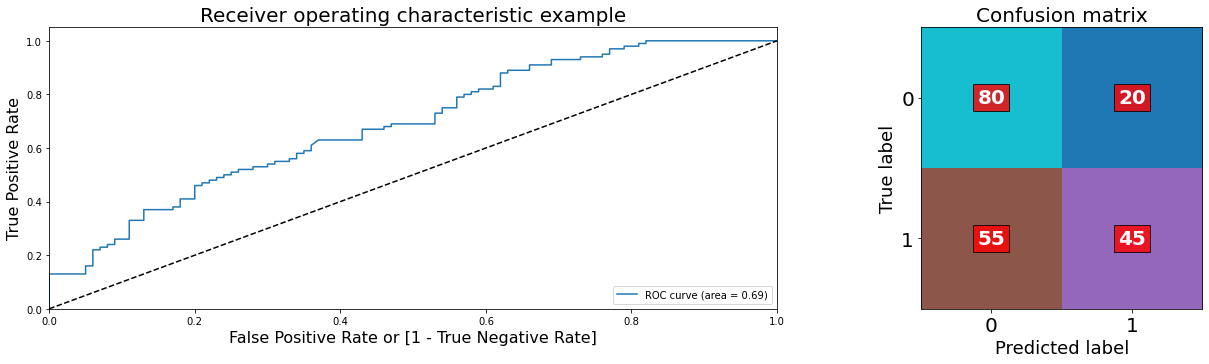

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.55658
Accuracy 0.62 AUC: 0.69 Recall: 0.45 Precision: 0.69 F1: 0.55
BOW_ADB


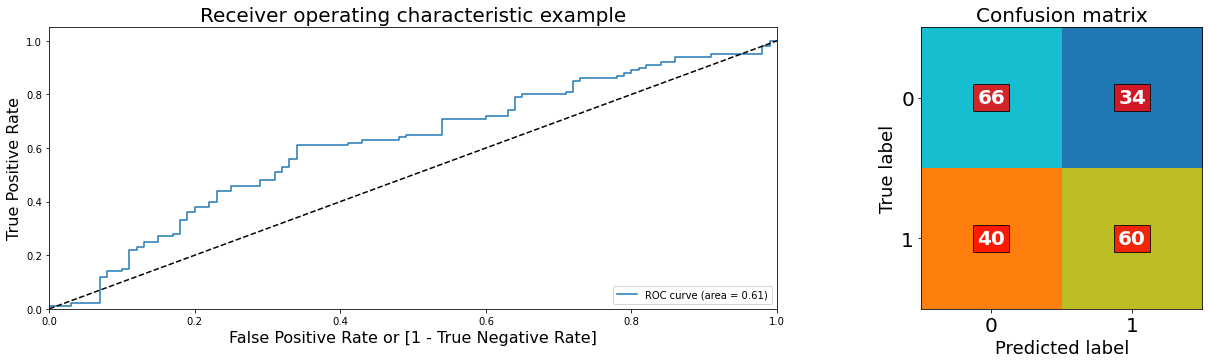

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.50019
Accuracy 0.63 AUC: 0.61 Recall: 0.6 Precision: 0.64 F1: 0.62
BOW_GBC


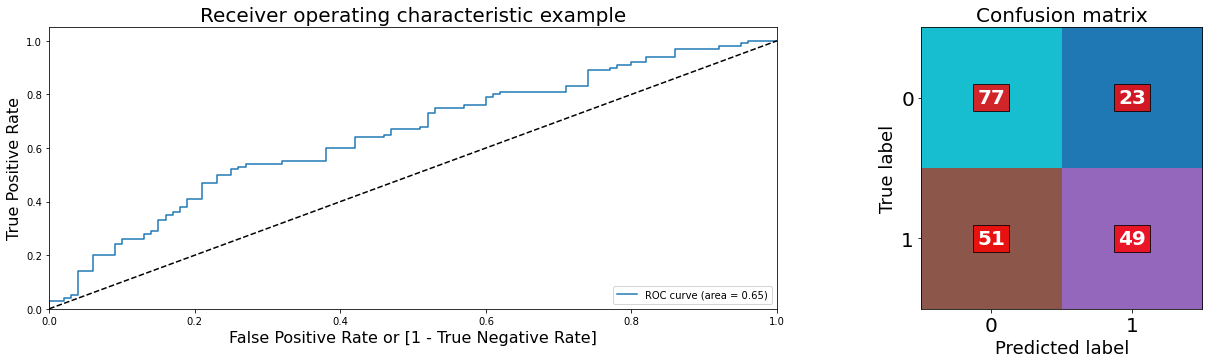

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.65  Threshold:0.52460
Accuracy 0.63 AUC: 0.65 Recall: 0.49 Precision: 0.68 F1: 0.57
BOW_RFC


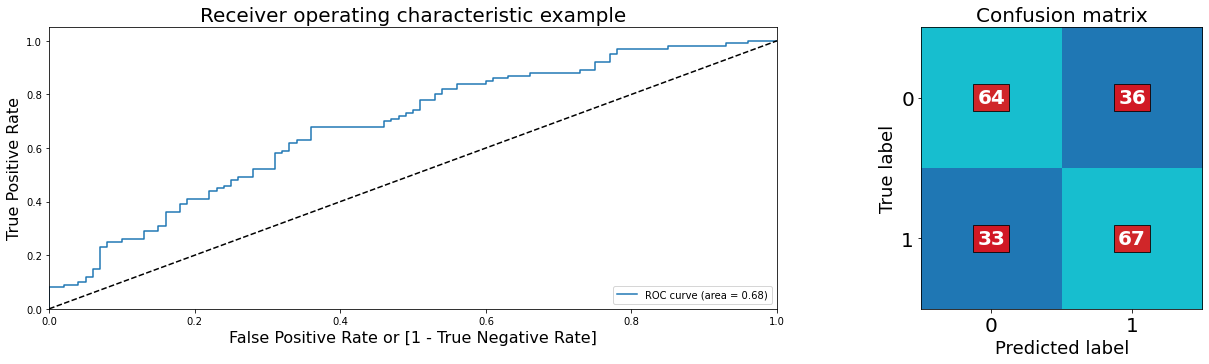

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.50442
Accuracy 0.66 AUC: 0.68 Recall: 0.67 Precision: 0.65 F1: 0.66
[14:37:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


BOW_XGB


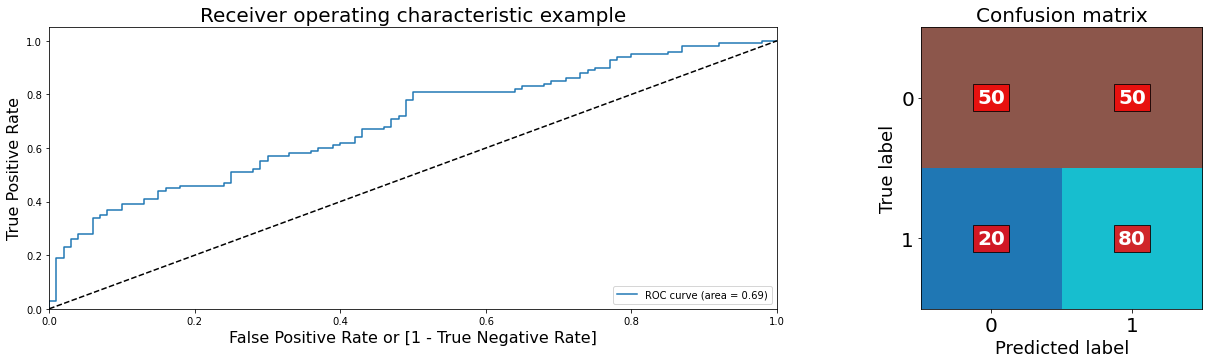

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.18185
Accuracy 0.65 AUC: 0.69 Recall: 0.8 Precision: 0.62 F1: 0.7
BOW_DT


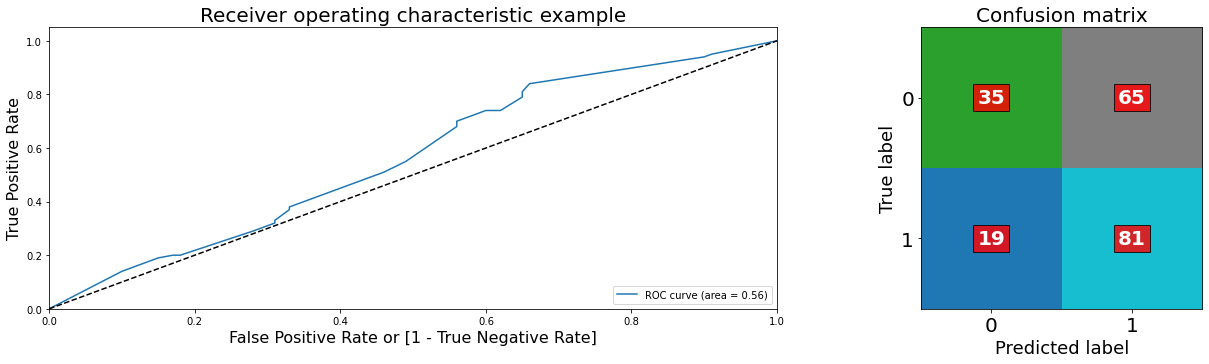

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.56  Threshold:0.24324
Accuracy 0.58 AUC: 0.56 Recall: 0.81 Precision: 0.55 F1: 0.66
BOW_Perceptron


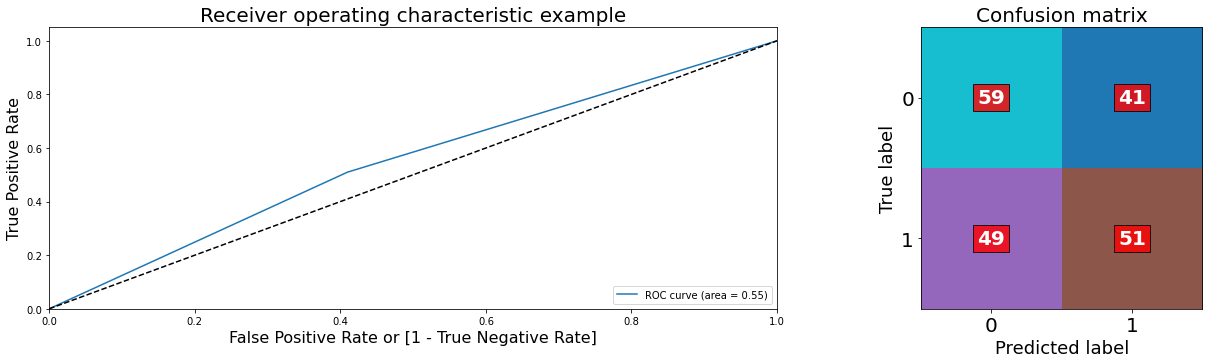

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.55  Threshold:1.00000
Accuracy 0.55 AUC: 0.55 Recall: 0.51 Precision: 0.55 F1: 0.53
IndicBERT
(1800, 768) (200, 768) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 768) (200, 768) (1800,) (200,)
IndicBERT_LR


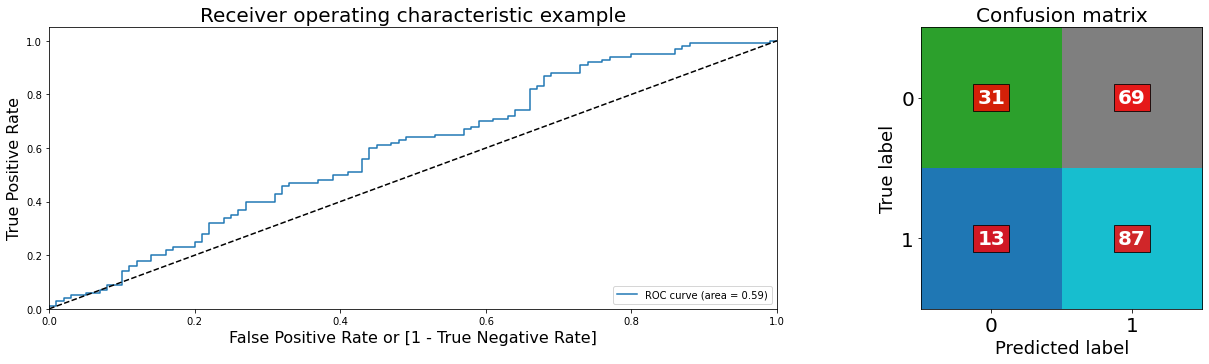

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.59  Threshold:0.49950
Accuracy 0.59 AUC: 0.59 Recall: 0.87 Precision: 0.56 F1: 0.68
IndicBERT_LGBM


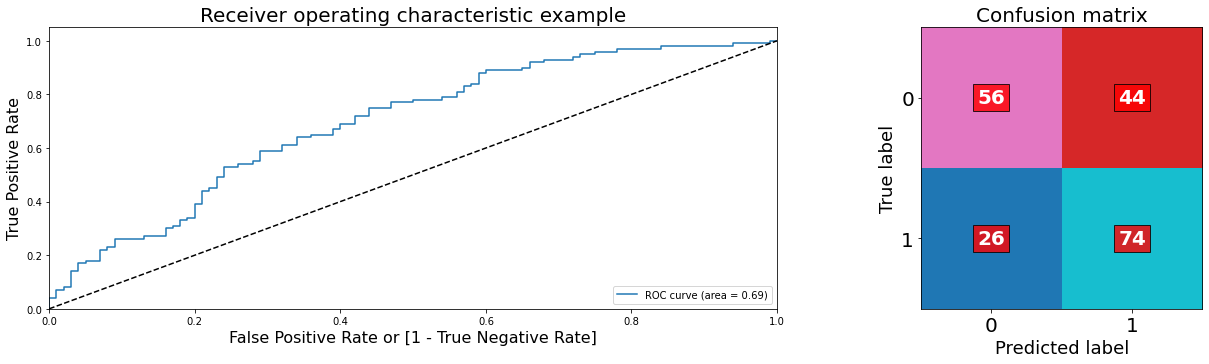

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.37953
Accuracy 0.65 AUC: 0.69 Recall: 0.74 Precision: 0.63 F1: 0.68
IndicBERT_NB


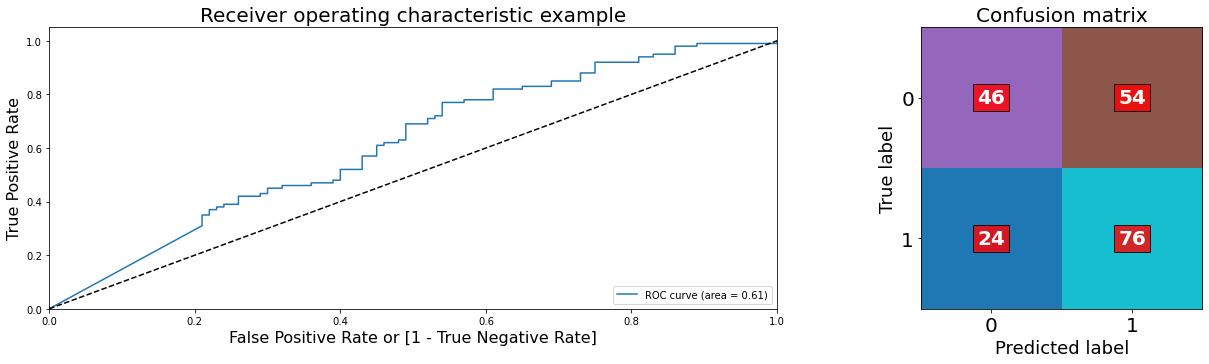

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.00076
Accuracy 0.61 AUC: 0.61 Recall: 0.76 Precision: 0.58 F1: 0.66
IndicBERT_SVC


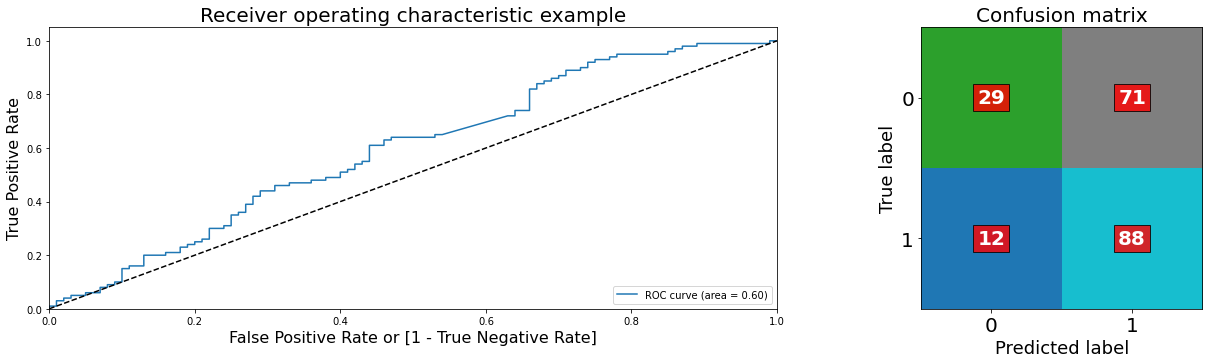

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.6  Threshold:0.48372
Accuracy 0.58 AUC: 0.6 Recall: 0.88 Precision: 0.55 F1: 0.68
IndicBERT_ADB


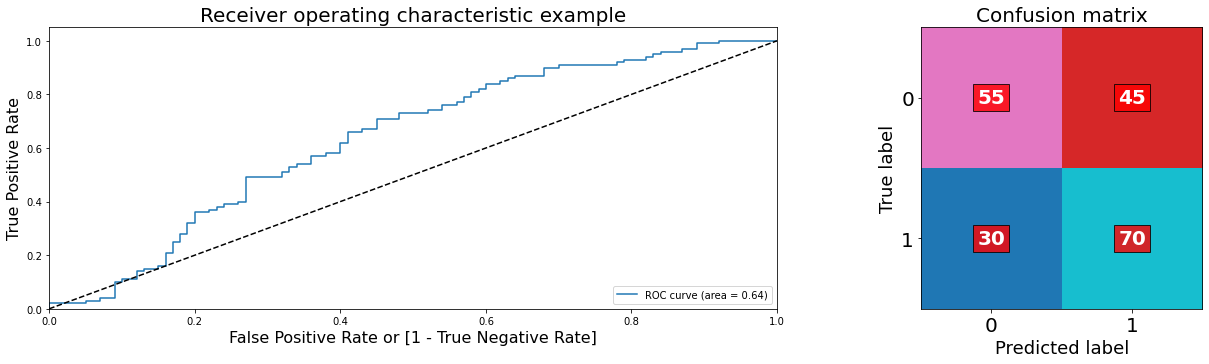

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.49839
Accuracy 0.62 AUC: 0.64 Recall: 0.7 Precision: 0.61 F1: 0.65
IndicBERT_GBC


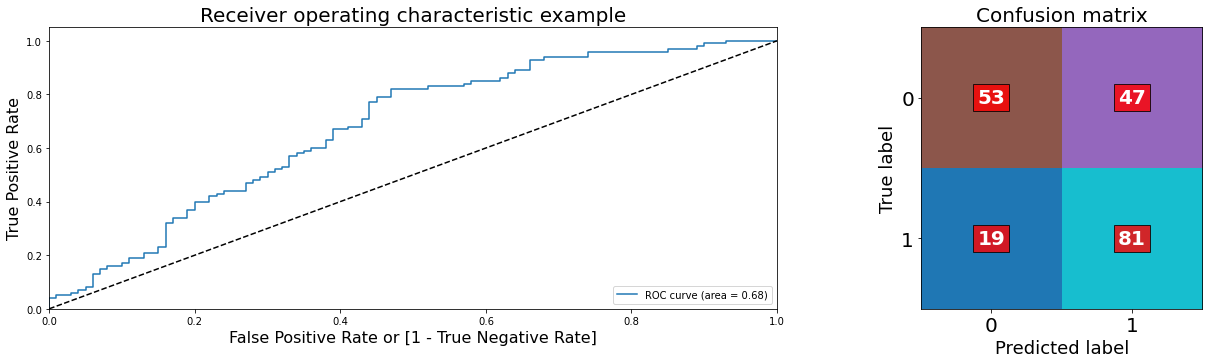

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.40358
Accuracy 0.67 AUC: 0.68 Recall: 0.81 Precision: 0.63 F1: 0.71
IndicBERT_RFC


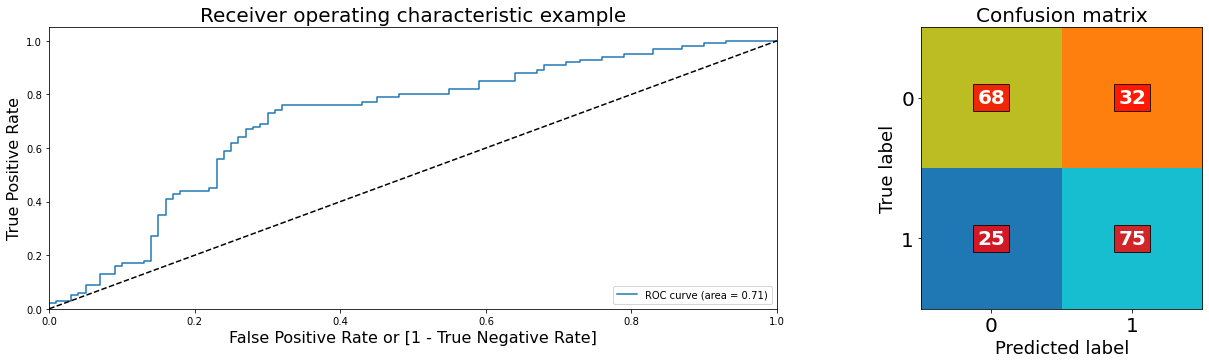

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.49281
Accuracy 0.72 AUC: 0.71 Recall: 0.75 Precision: 0.7 F1: 0.72
[14:39:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


IndicBERT_XGB


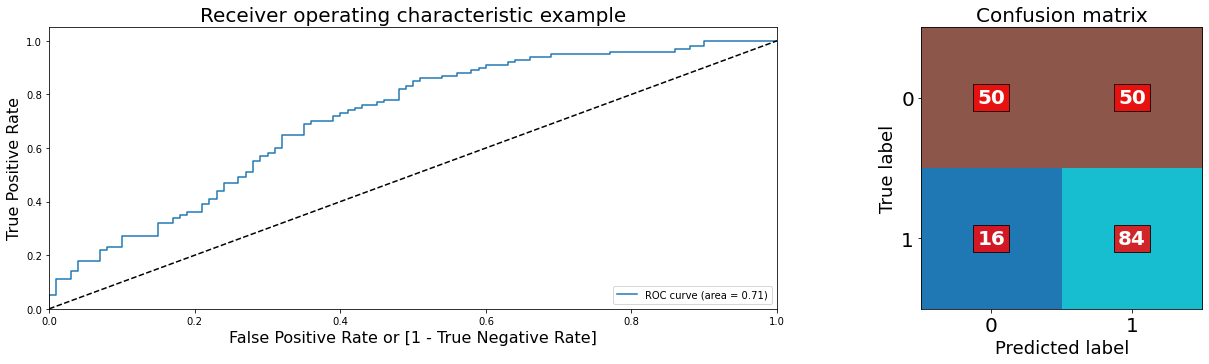

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.09818
Accuracy 0.67 AUC: 0.71 Recall: 0.84 Precision: 0.63 F1: 0.72
IndicBERT_DT


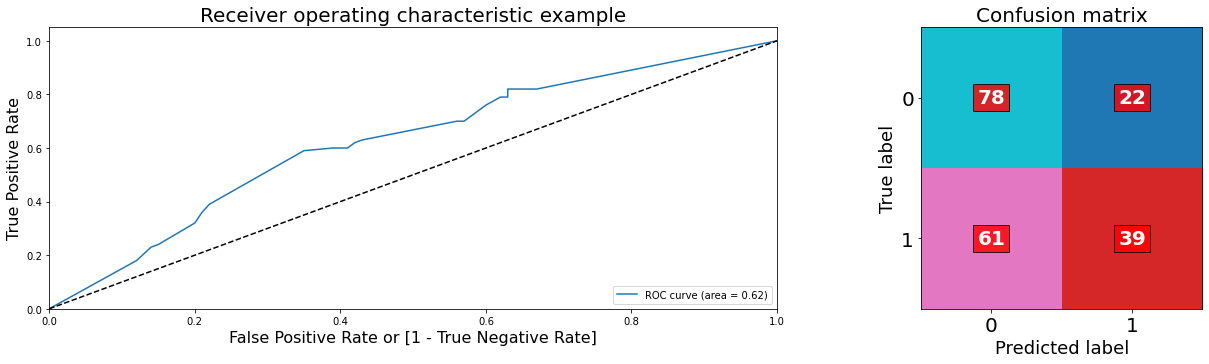

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.62  Threshold:0.62334
Accuracy 0.58 AUC: 0.62 Recall: 0.39 Precision: 0.64 F1: 0.48
IndicBERT_Perceptron


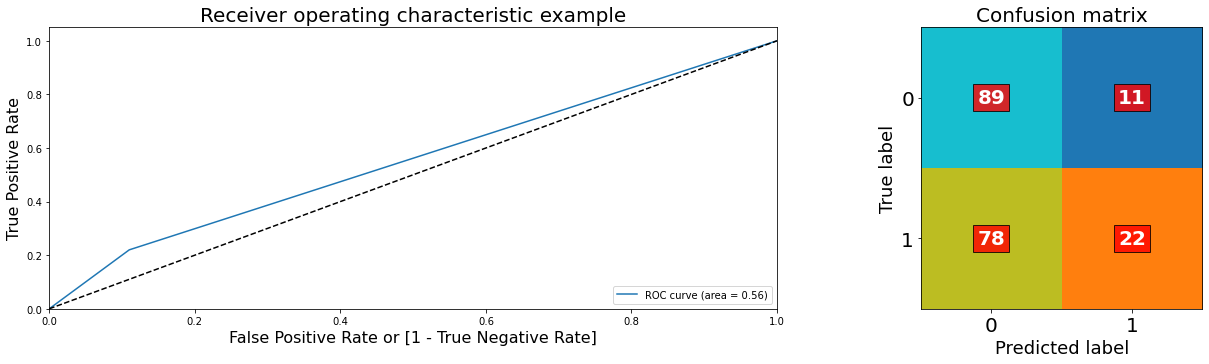

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.56  Threshold:1.00000
Accuracy 0.56 AUC: 0.56 Recall: 0.22 Precision: 0.67 F1: 0.33
mBERT
(1800, 768) (200, 768) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 768) (200, 768) (1800,) (200,)
mBERT_LR


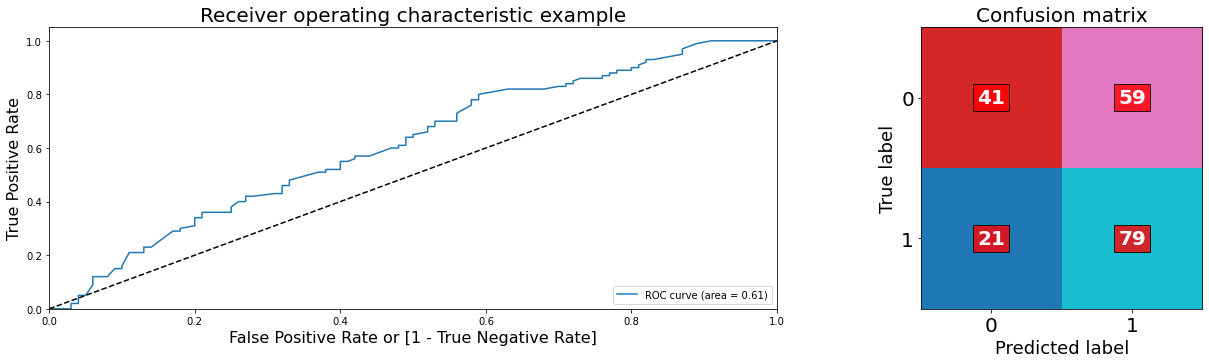

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.47516
Accuracy 0.6 AUC: 0.61 Recall: 0.79 Precision: 0.57 F1: 0.66
mBERT_LGBM


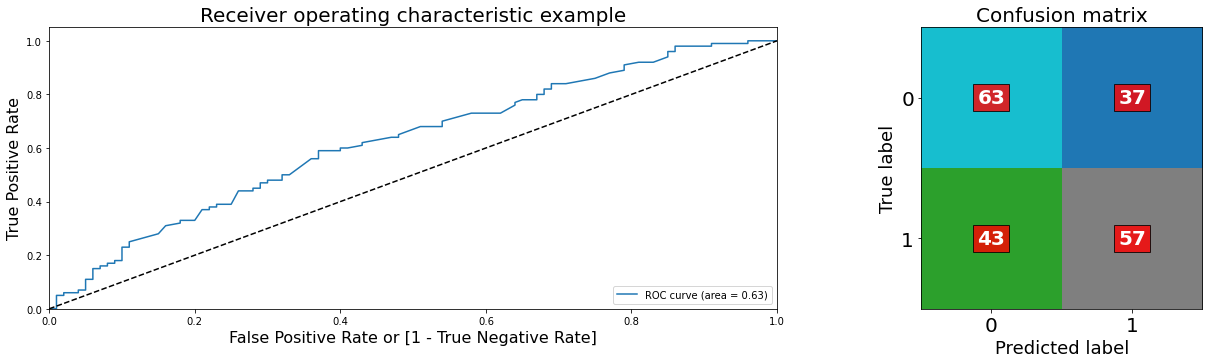

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.52291
Accuracy 0.6 AUC: 0.63 Recall: 0.57 Precision: 0.61 F1: 0.59
mBERT_NB


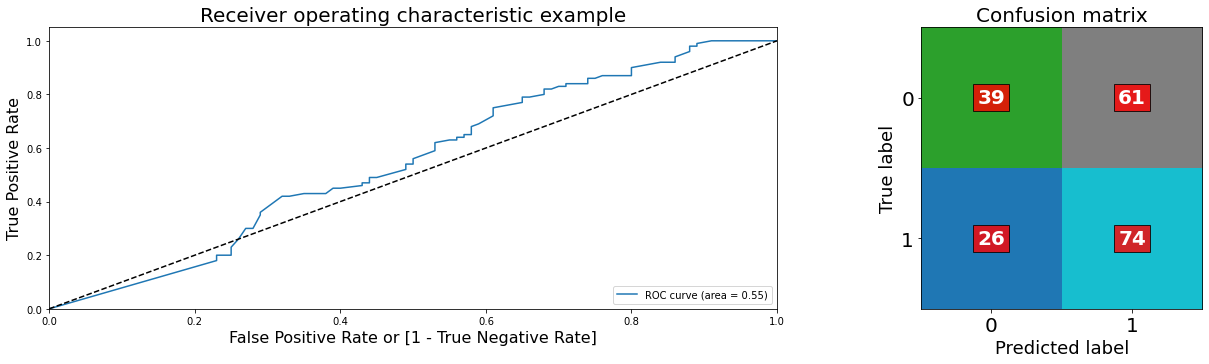

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.55  Threshold:0.00000
Accuracy 0.56 AUC: 0.55 Recall: 0.74 Precision: 0.55 F1: 0.63
mBERT_SVC


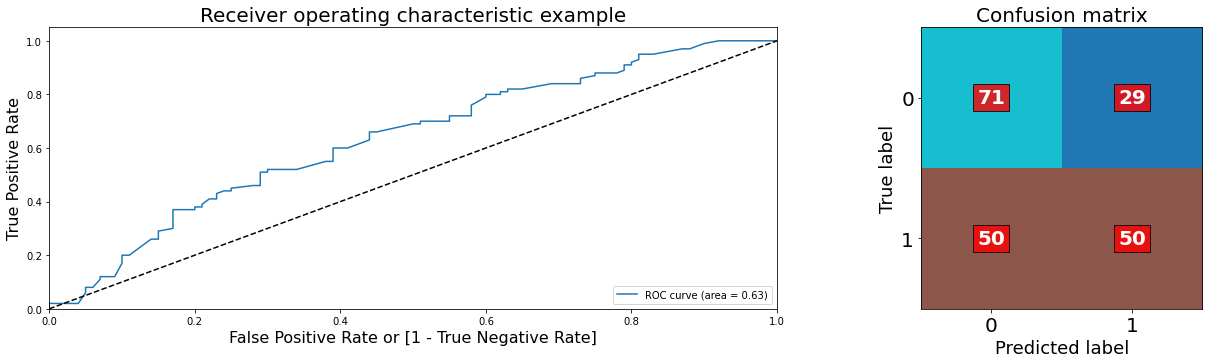

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.56595
Accuracy 0.6 AUC: 0.63 Recall: 0.5 Precision: 0.63 F1: 0.56
mBERT_ADB


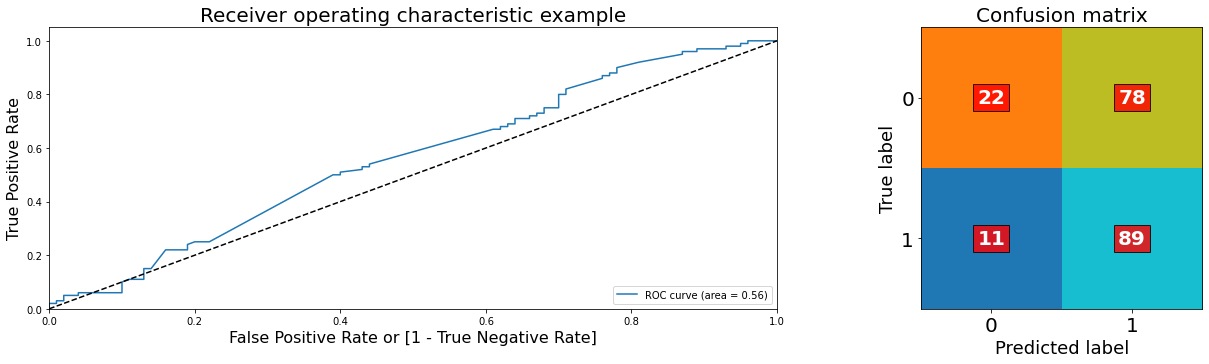

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.56  Threshold:0.49417
Accuracy 0.56 AUC: 0.56 Recall: 0.89 Precision: 0.53 F1: 0.67
mBERT_GBC


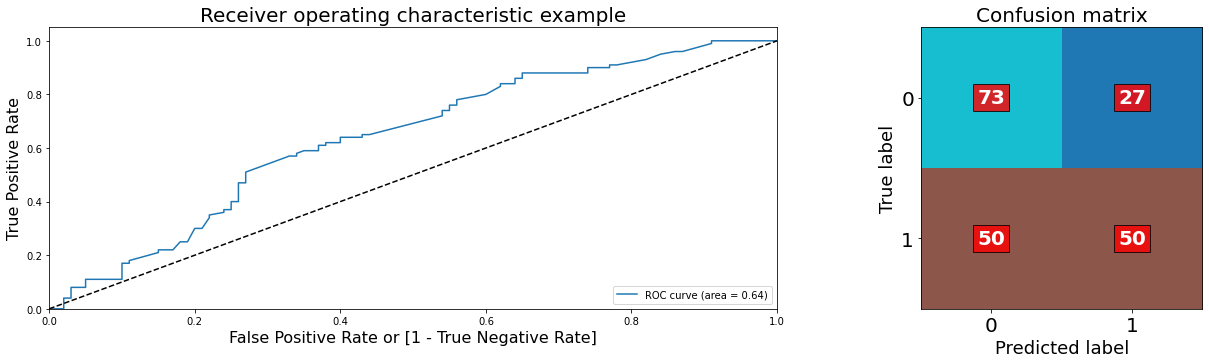

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.57662
Accuracy 0.62 AUC: 0.64 Recall: 0.5 Precision: 0.65 F1: 0.56
mBERT_RFC


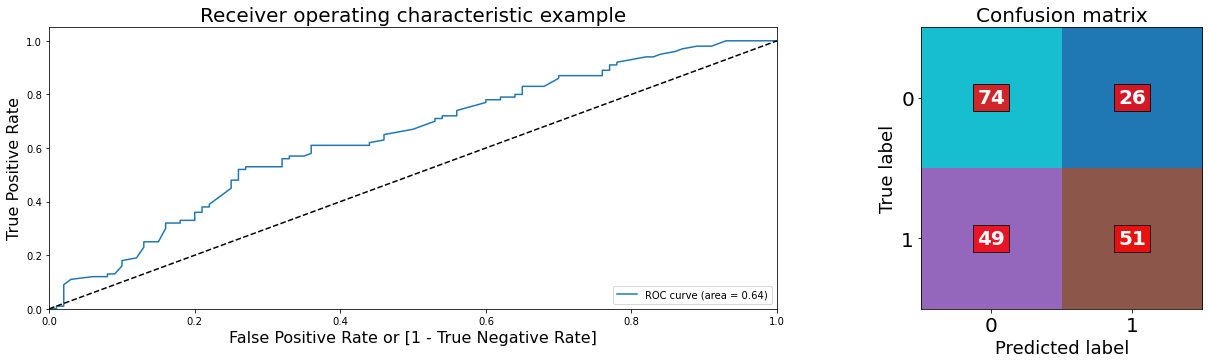

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.56803
Accuracy 0.62 AUC: 0.64 Recall: 0.51 Precision: 0.66 F1: 0.58
[14:43:04] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


mBERT_XGB


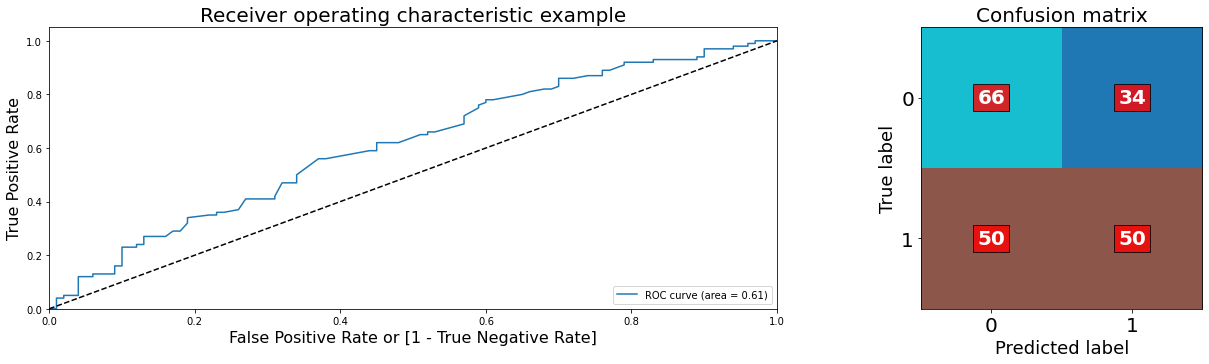

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.52629
Accuracy 0.58 AUC: 0.61 Recall: 0.5 Precision: 0.6 F1: 0.54
mBERT_DT


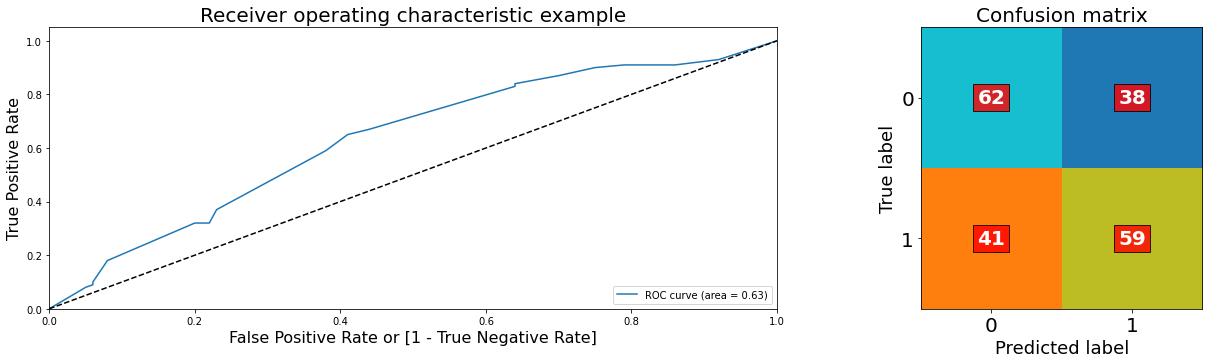

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.52632
Accuracy 0.6 AUC: 0.63 Recall: 0.59 Precision: 0.61 F1: 0.6
mBERT_Perceptron


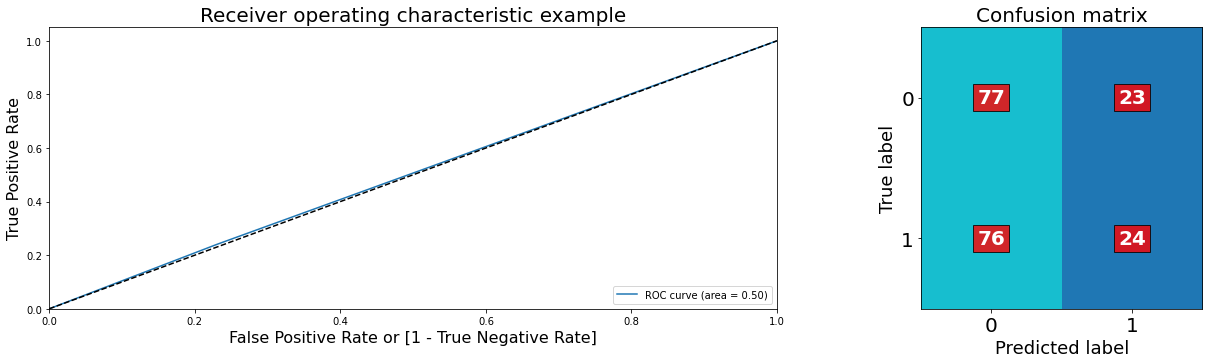

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.5  Threshold:1.00000
Accuracy 0.5 AUC: 0.5 Recall: 0.24 Precision: 0.51 F1: 0.33
fastText
(1800, 50) (200, 50) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 50) (200, 50) (1800,) (200,)
fastText_LR


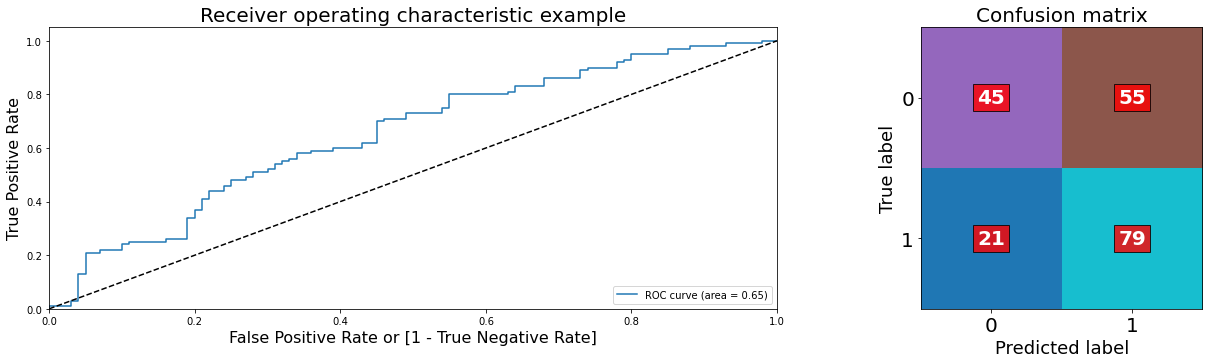

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.65  Threshold:0.51048
Accuracy 0.62 AUC: 0.65 Recall: 0.79 Precision: 0.59 F1: 0.68
fastText_LGBM


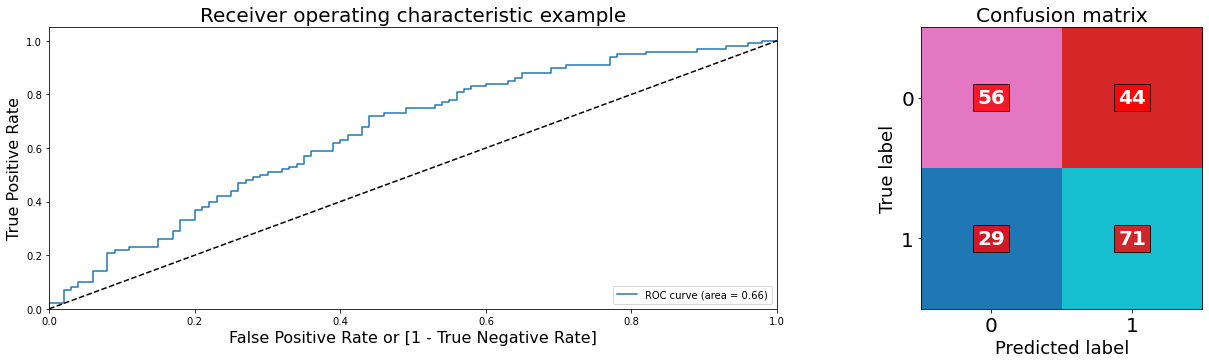

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.47413
Accuracy 0.64 AUC: 0.66 Recall: 0.71 Precision: 0.62 F1: 0.66
fastText_NB


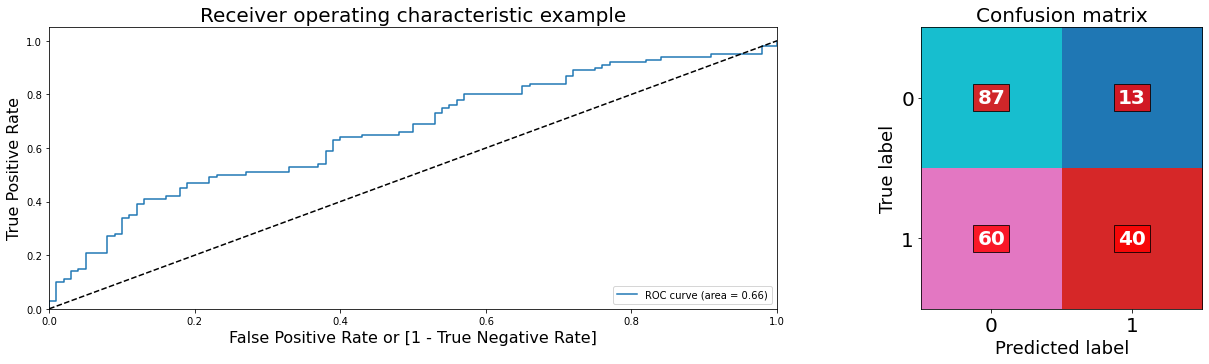

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.98828
Accuracy 0.64 AUC: 0.66 Recall: 0.4 Precision: 0.75 F1: 0.52
fastText_SVC


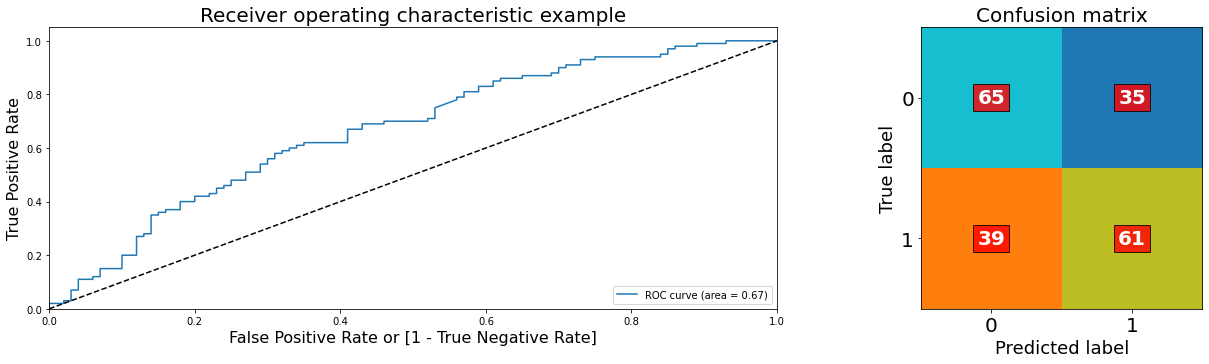

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.67  Threshold:0.58837
Accuracy 0.63 AUC: 0.67 Recall: 0.61 Precision: 0.64 F1: 0.62
fastText_ADB


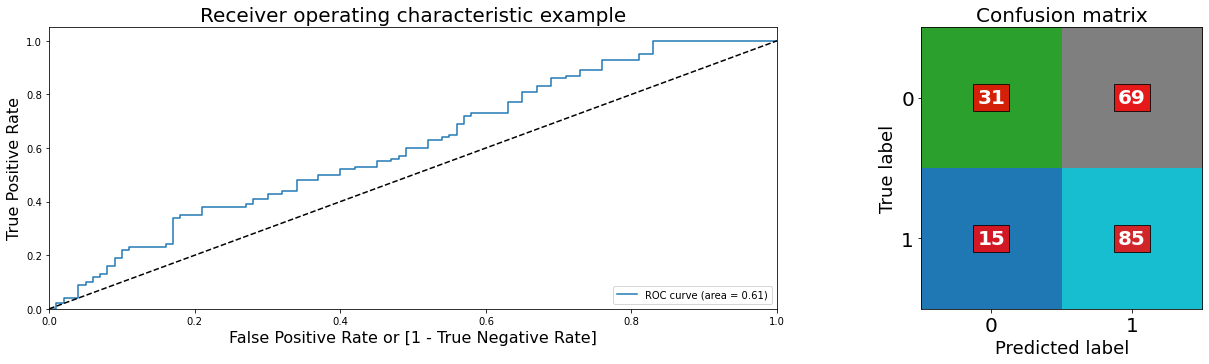

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.61  Threshold:0.49643
Accuracy 0.58 AUC: 0.61 Recall: 0.85 Precision: 0.55 F1: 0.67
fastText_GBC


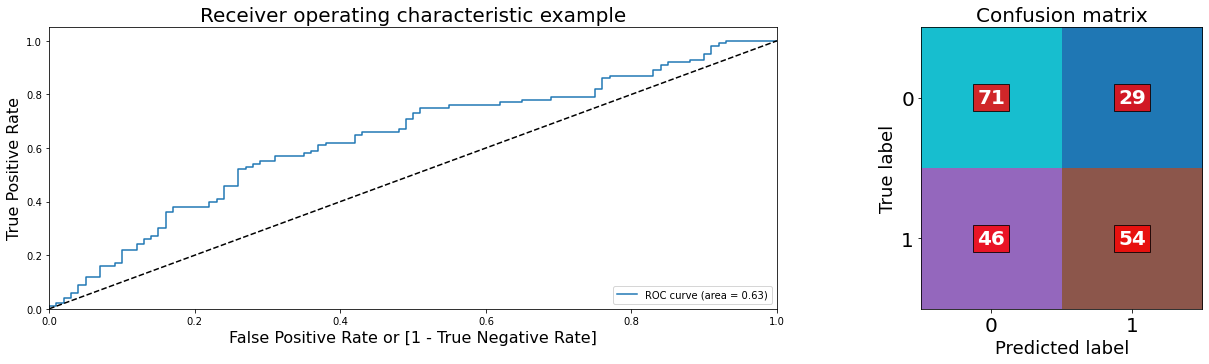

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.57442
Accuracy 0.62 AUC: 0.63 Recall: 0.54 Precision: 0.65 F1: 0.59
fastText_RFC


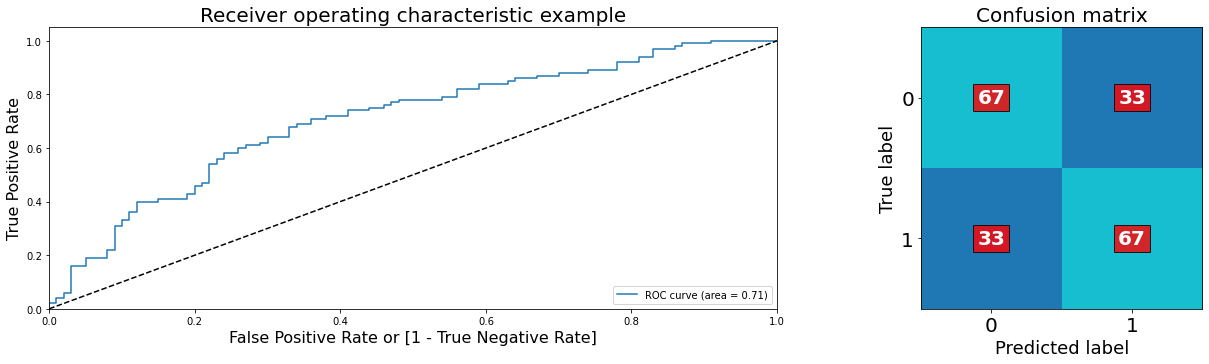

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.59307
Accuracy 0.67 AUC: 0.71 Recall: 0.67 Precision: 0.67 F1: 0.67
[14:45:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


fastText_XGB


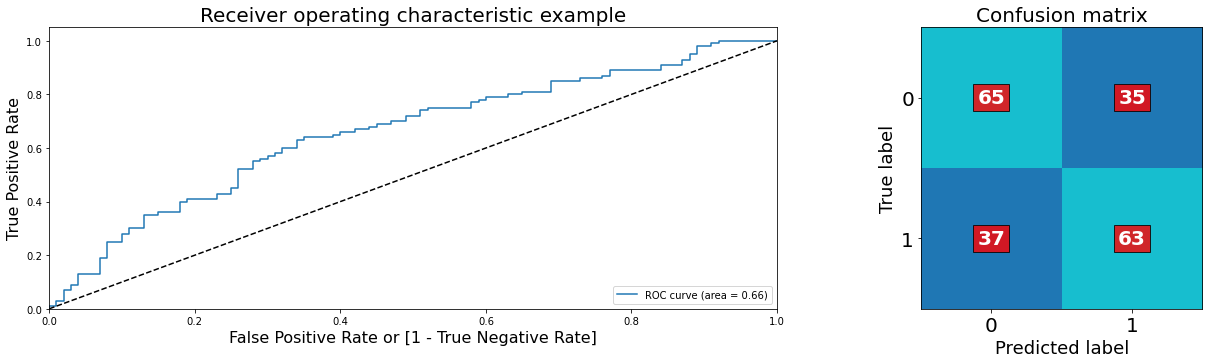

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.66  Threshold:0.42865
Accuracy 0.64 AUC: 0.66 Recall: 0.63 Precision: 0.64 F1: 0.64
fastText_DT


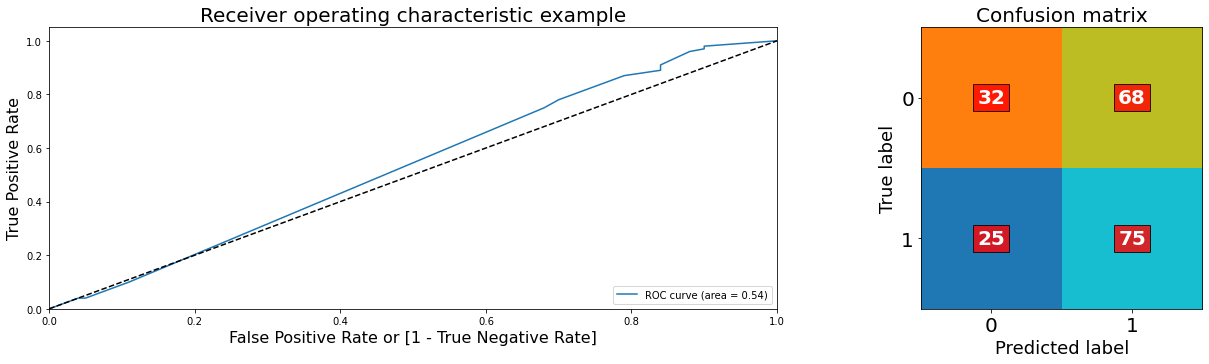

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.54  Threshold:0.66667
Accuracy 0.54 AUC: 0.54 Recall: 0.75 Precision: 0.52 F1: 0.62
fastText_Perceptron


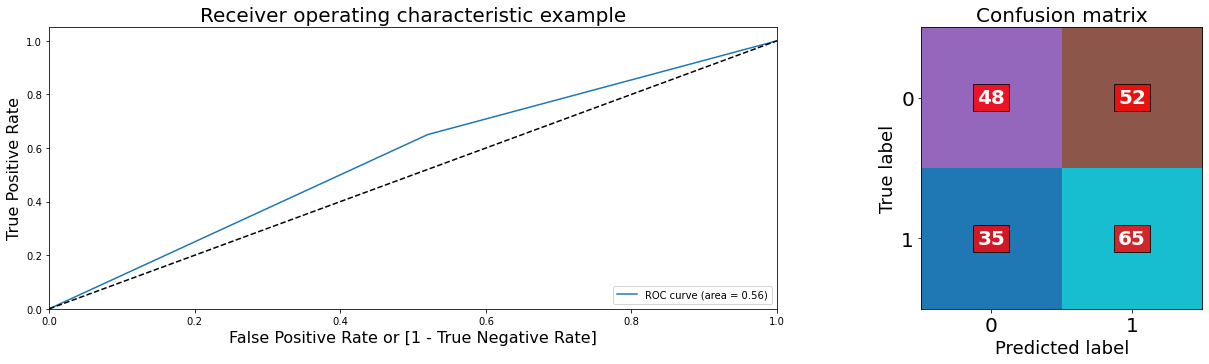

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.56  Threshold:1.00000
Accuracy 0.56 AUC: 0.56 Recall: 0.65 Precision: 0.56 F1: 0.6
IndicFT
(1800, 300) (200, 300) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 300) (200, 300) (1800,) (200,)
IndicFT_LR


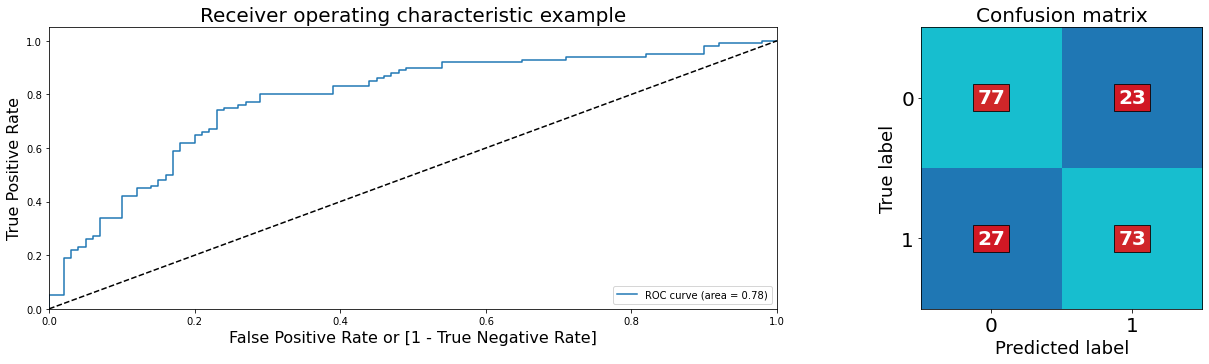

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.49865
Accuracy 0.75 AUC: 0.78 Recall: 0.73 Precision: 0.76 F1: 0.74
IndicFT_LGBM


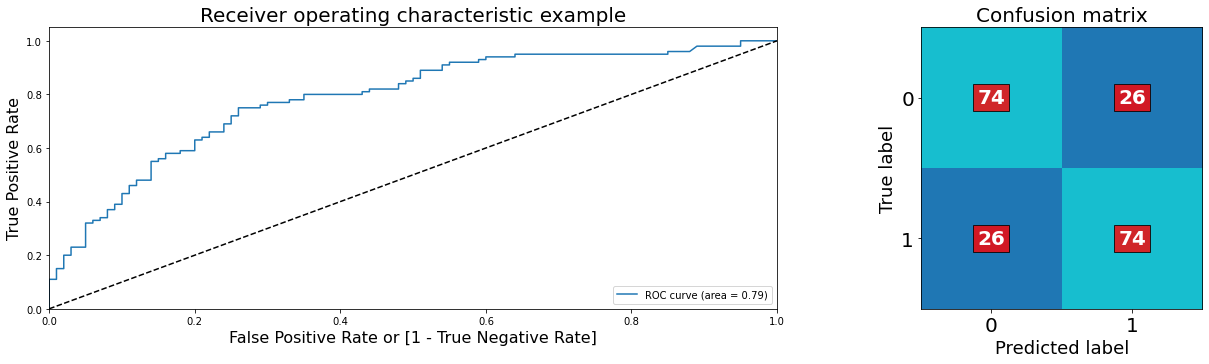

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.14664
Accuracy 0.74 AUC: 0.79 Recall: 0.74 Precision: 0.74 F1: 0.74
IndicFT_NB


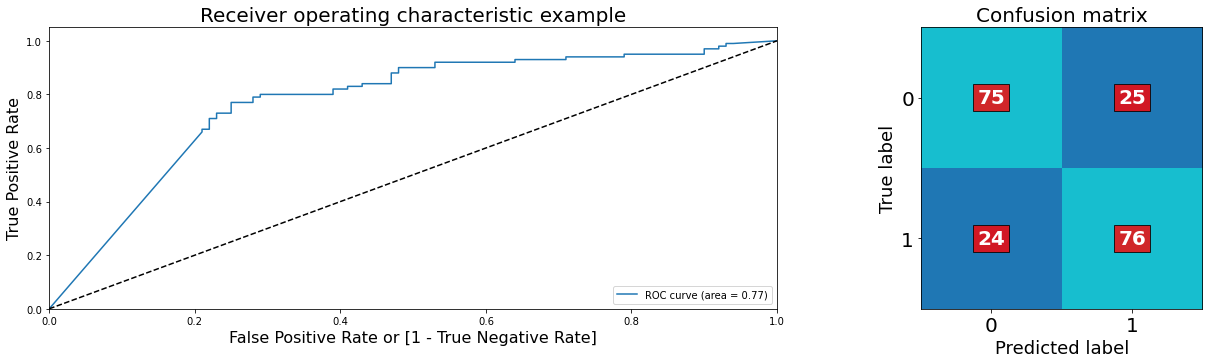

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.77  Threshold:0.00000
Accuracy 0.76 AUC: 0.77 Recall: 0.76 Precision: 0.75 F1: 0.76
IndicFT_SVC


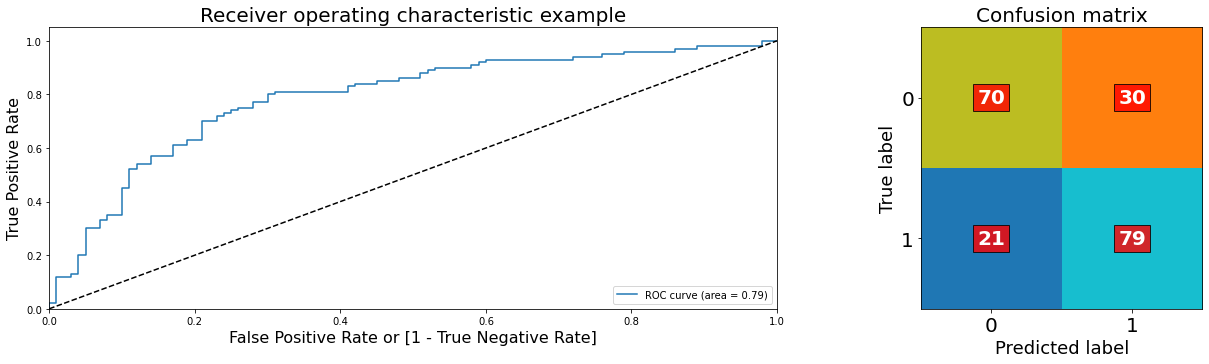

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.13088
Accuracy 0.74 AUC: 0.79 Recall: 0.79 Precision: 0.72 F1: 0.76
IndicFT_ADB


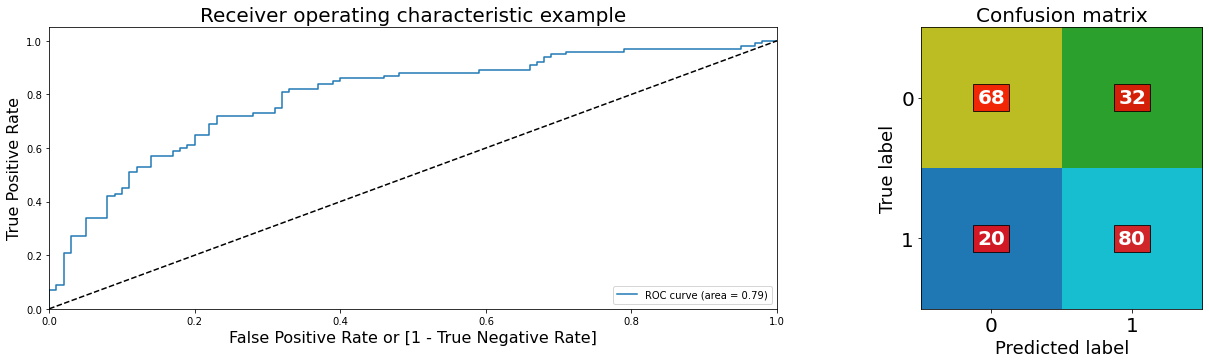

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.47409
Accuracy 0.74 AUC: 0.79 Recall: 0.8 Precision: 0.71 F1: 0.75
IndicFT_GBC


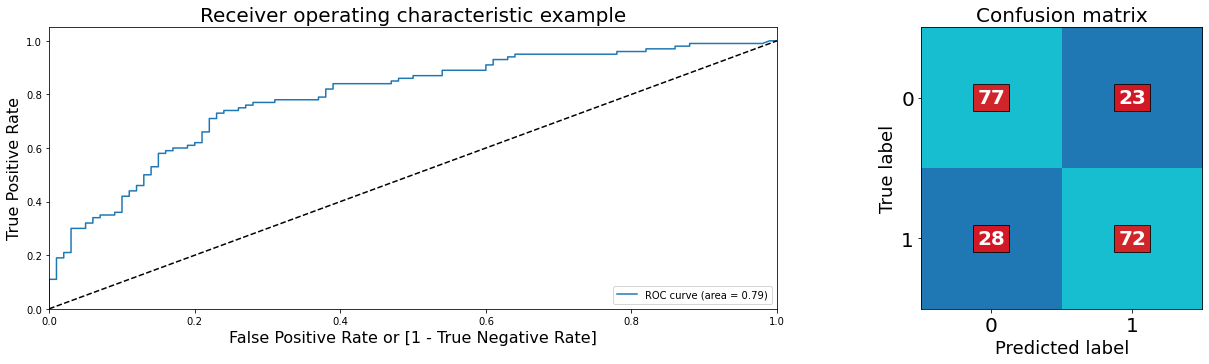

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.29278
Accuracy 0.74 AUC: 0.79 Recall: 0.72 Precision: 0.76 F1: 0.74
IndicFT_RFC


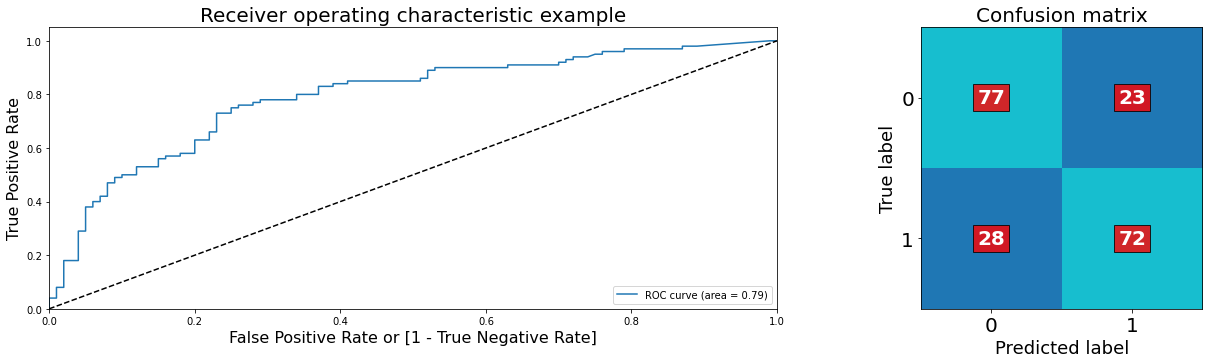

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.43847
Accuracy 0.74 AUC: 0.79 Recall: 0.72 Precision: 0.76 F1: 0.74
[14:46:26] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


IndicFT_XGB


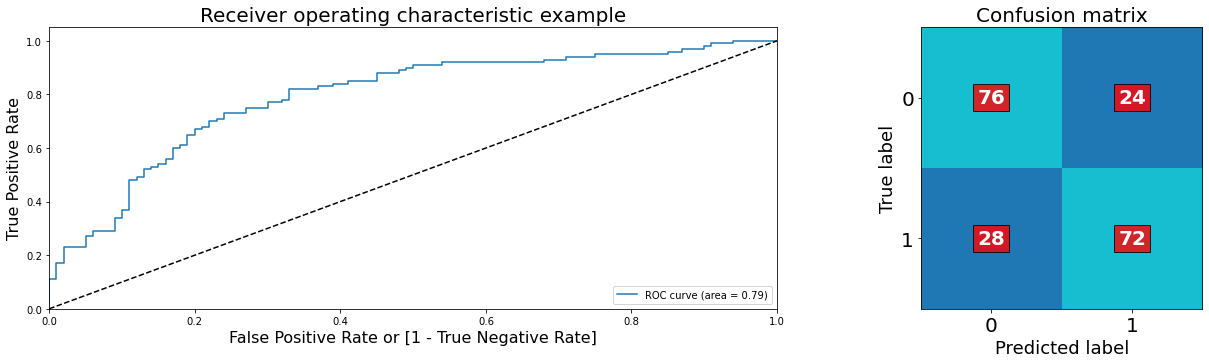

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.23582
Accuracy 0.74 AUC: 0.79 Recall: 0.72 Precision: 0.75 F1: 0.73
IndicFT_DT


D:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


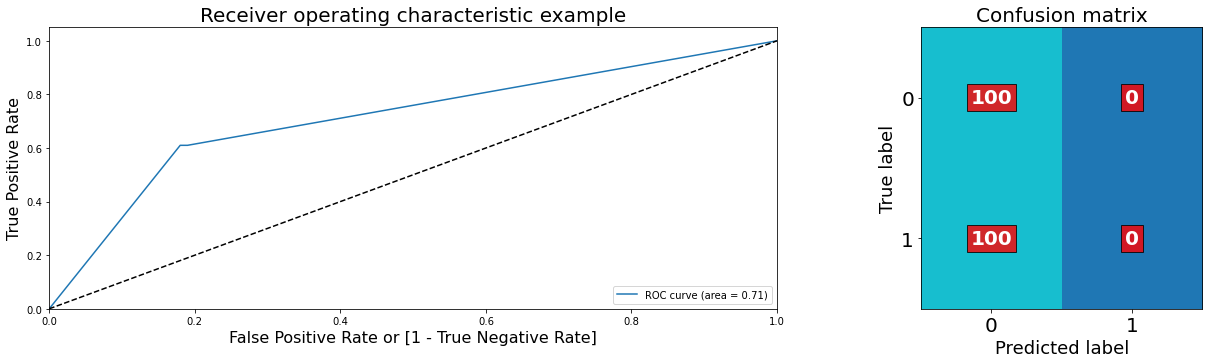

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:1.00000
Accuracy 0.5 AUC: 0.71 Recall: 0.0 Precision: 0.0 F1: 0.0
IndicFT_Perceptron


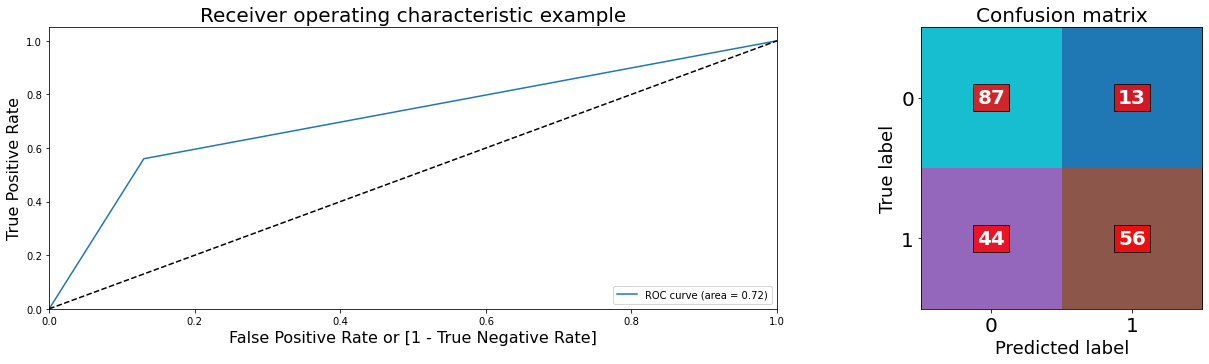

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.72  Threshold:1.00000
Accuracy 0.72 AUC: 0.72 Recall: 0.56 Precision: 0.81 F1: 0.66
fastTextWiki
(1800, 300) (200, 300) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 300) (200, 300) (1800,) (200,)
fastTextWiki_LR


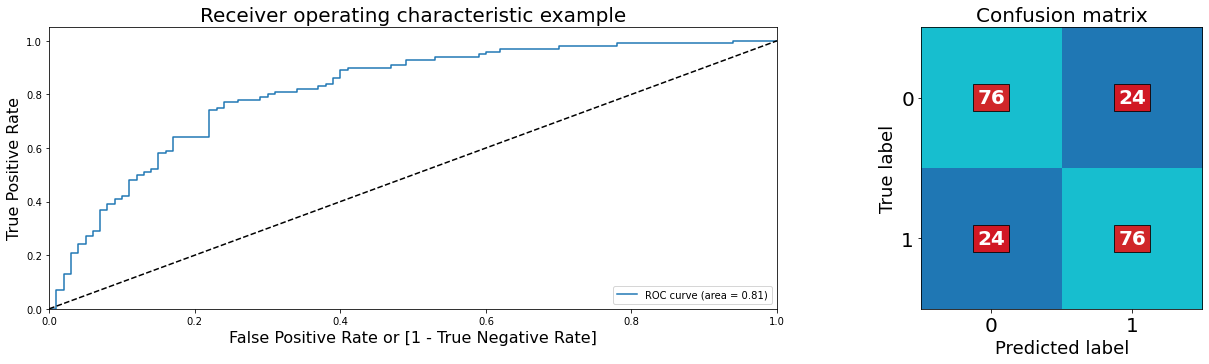

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.48921
Accuracy 0.76 AUC: 0.81 Recall: 0.76 Precision: 0.76 F1: 0.76
fastTextWiki_LGBM


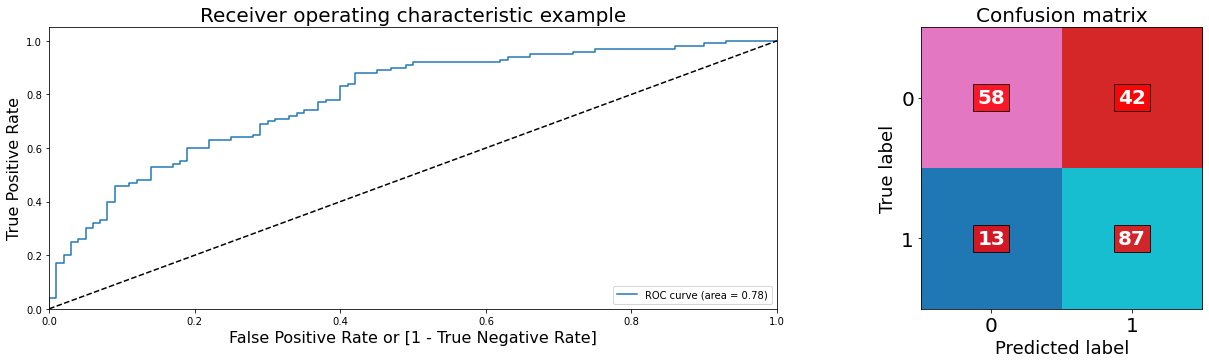

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.05700
Accuracy 0.72 AUC: 0.78 Recall: 0.87 Precision: 0.67 F1: 0.76
fastTextWiki_NB


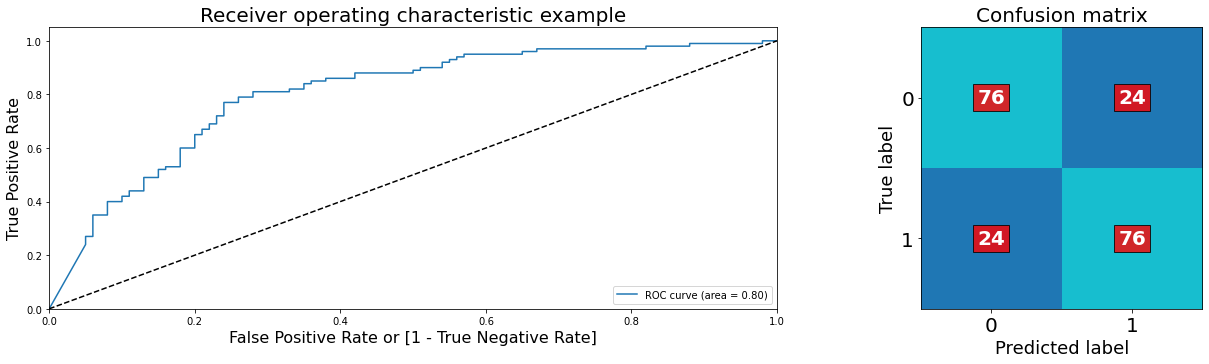

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.65750
Accuracy 0.76 AUC: 0.8 Recall: 0.76 Precision: 0.76 F1: 0.76
fastTextWiki_SVC


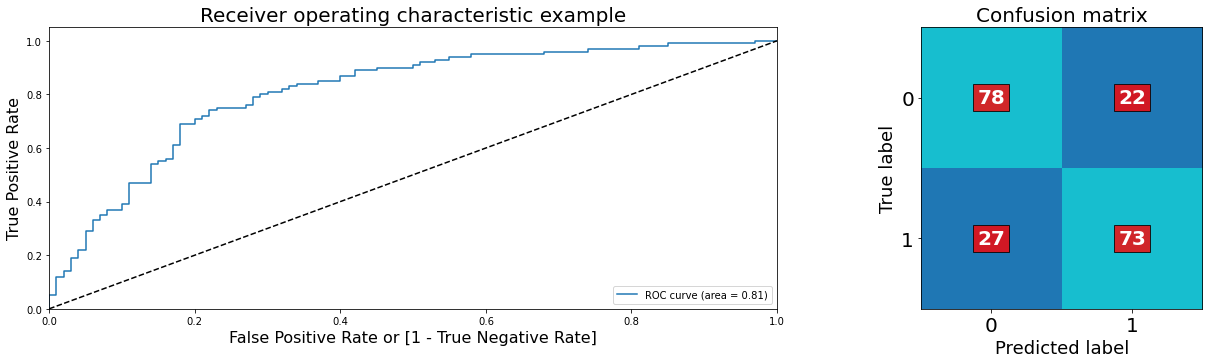

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.81  Threshold:0.29814
Accuracy 0.76 AUC: 0.81 Recall: 0.73 Precision: 0.77 F1: 0.75
fastTextWiki_ADB


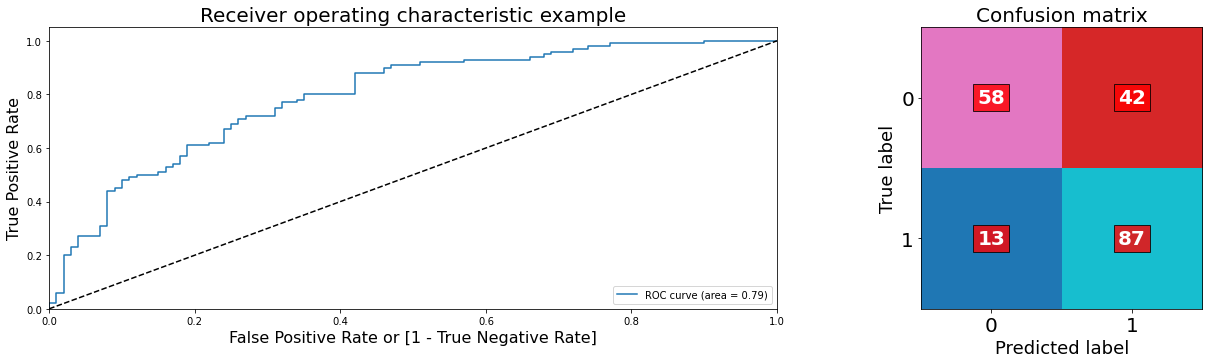

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.47822
Accuracy 0.72 AUC: 0.79 Recall: 0.87 Precision: 0.67 F1: 0.76
fastTextWiki_GBC


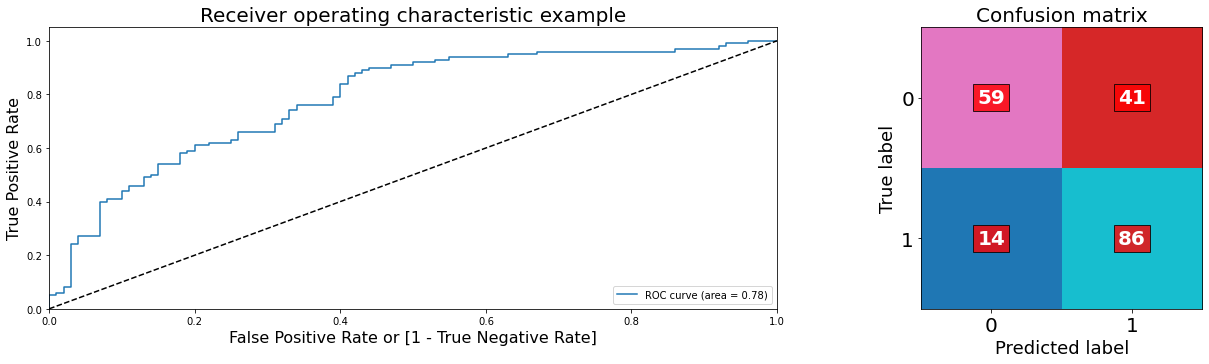

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.17352
Accuracy 0.72 AUC: 0.78 Recall: 0.86 Precision: 0.68 F1: 0.76
fastTextWiki_RFC


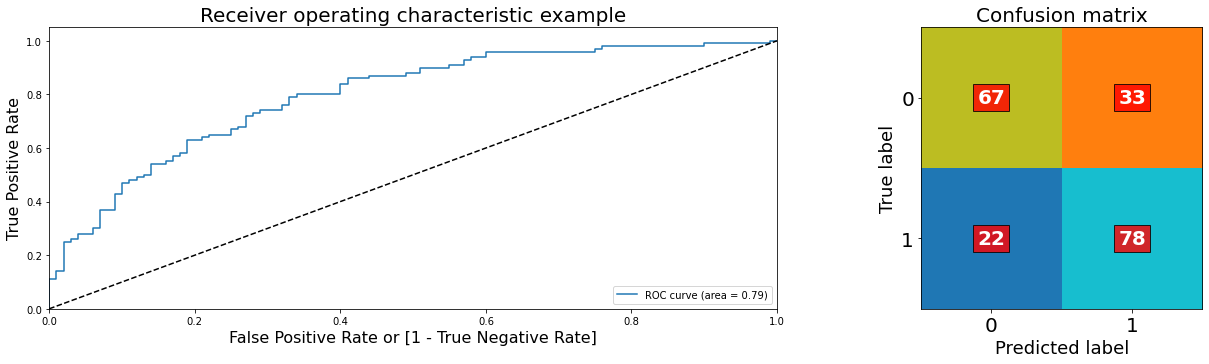

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.41113
Accuracy 0.72 AUC: 0.79 Recall: 0.78 Precision: 0.7 F1: 0.74
[14:47:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


fastTextWiki_XGB


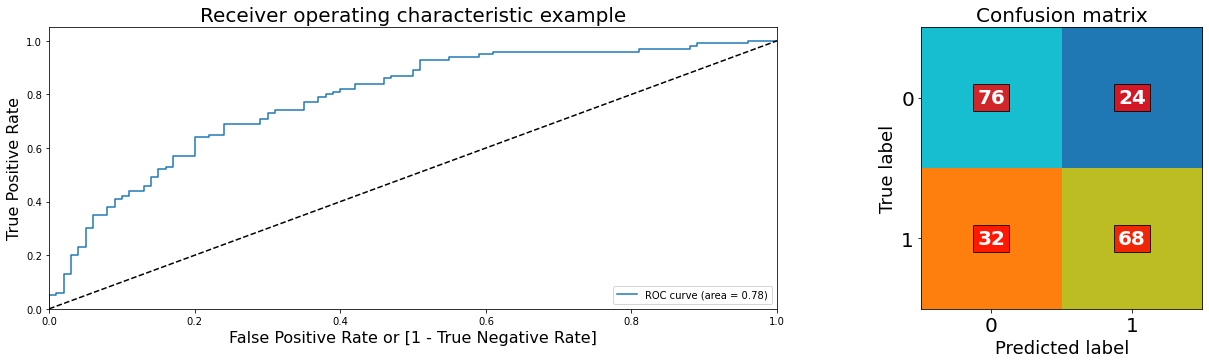

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.37963
Accuracy 0.72 AUC: 0.78 Recall: 0.68 Precision: 0.74 F1: 0.71
fastTextWiki_DT


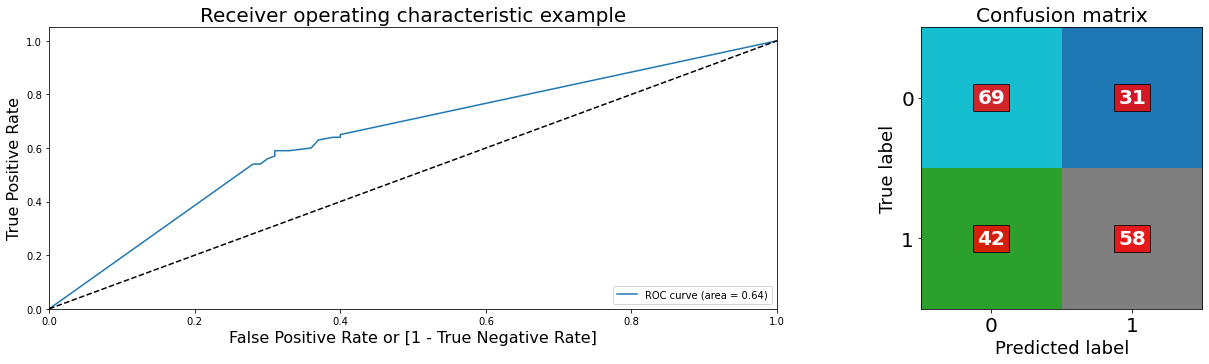

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.72727
Accuracy 0.64 AUC: 0.64 Recall: 0.58 Precision: 0.65 F1: 0.61
fastTextWiki_Perceptron


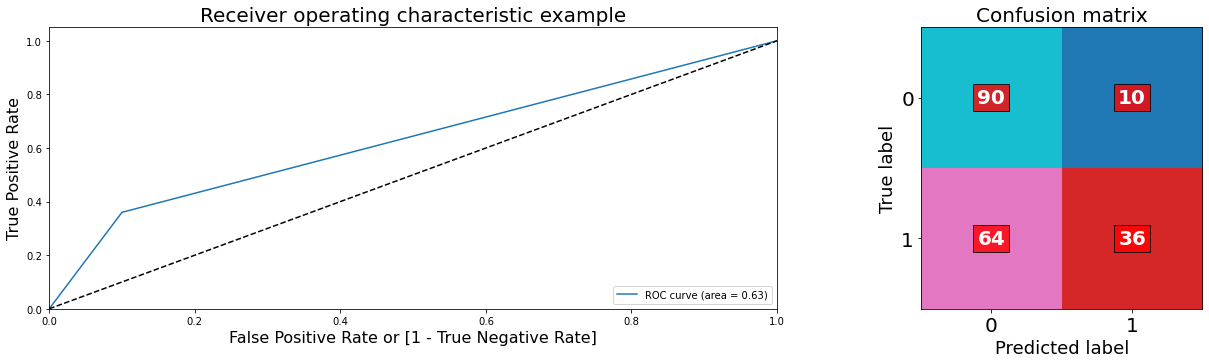

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:1.00000
Accuracy 0.63 AUC: 0.63 Recall: 0.36 Precision: 0.78 F1: 0.49
Lexical
(1800, 20) (200, 20) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 20) (200, 20) (1800,) (200,)
Lexical_LR


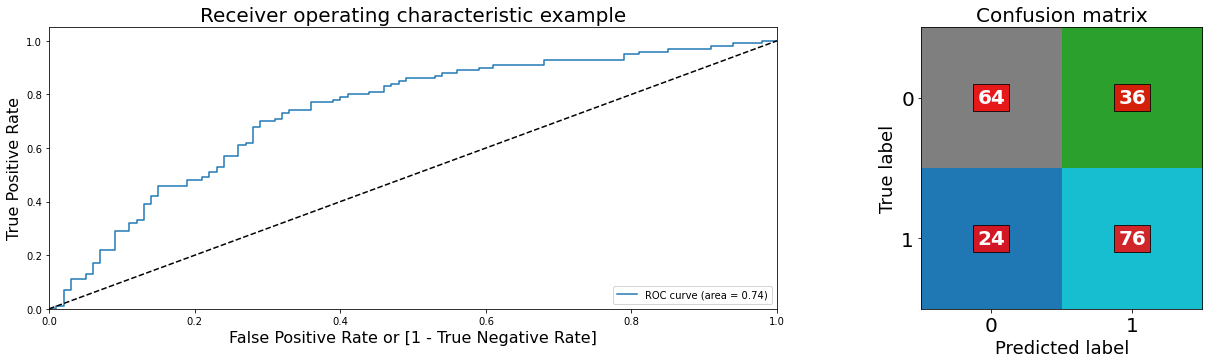

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.74  Threshold:0.45589
Accuracy 0.7 AUC: 0.74 Recall: 0.76 Precision: 0.68 F1: 0.72
Lexical_LGBM


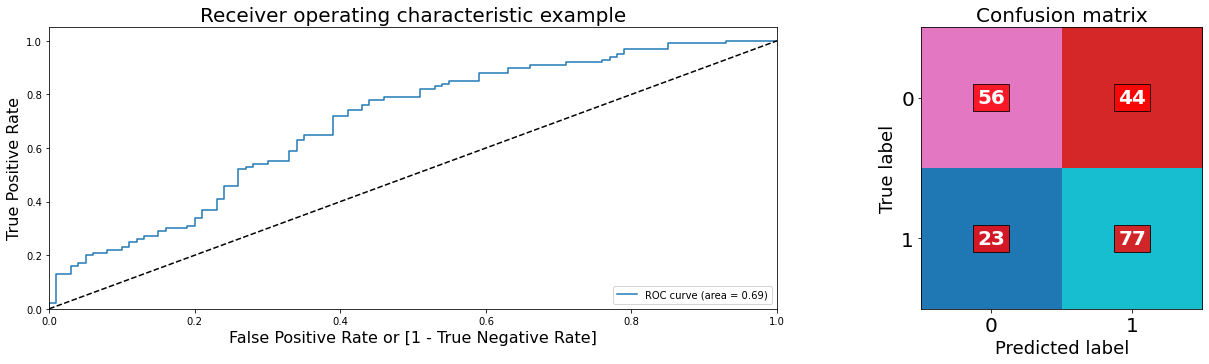

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.44883
Accuracy 0.66 AUC: 0.69 Recall: 0.77 Precision: 0.64 F1: 0.7
Lexical_NB


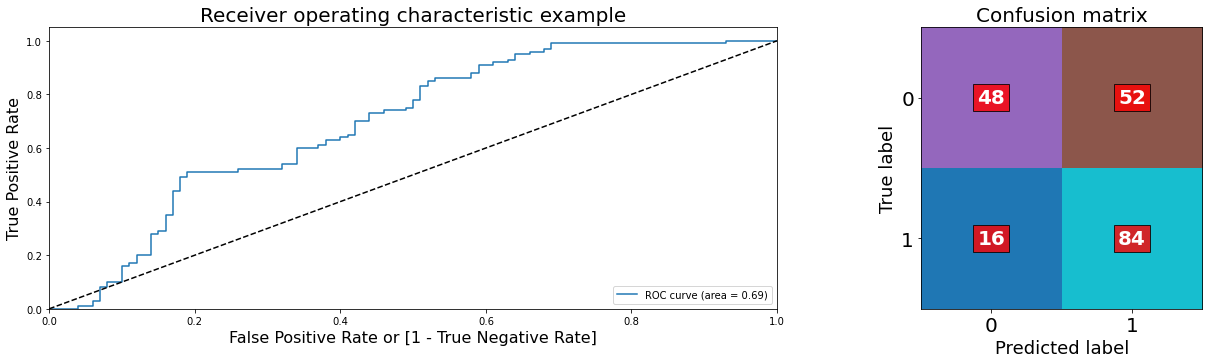

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.69  Threshold:0.18766
Accuracy 0.66 AUC: 0.69 Recall: 0.84 Precision: 0.62 F1: 0.71
Lexical_SVC


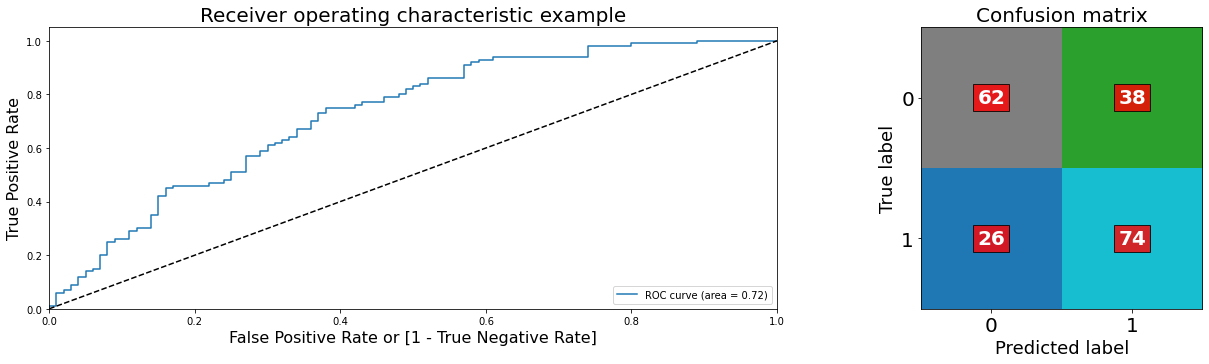

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.72  Threshold:0.48005
Accuracy 0.68 AUC: 0.72 Recall: 0.74 Precision: 0.66 F1: 0.7
Lexical_ADB


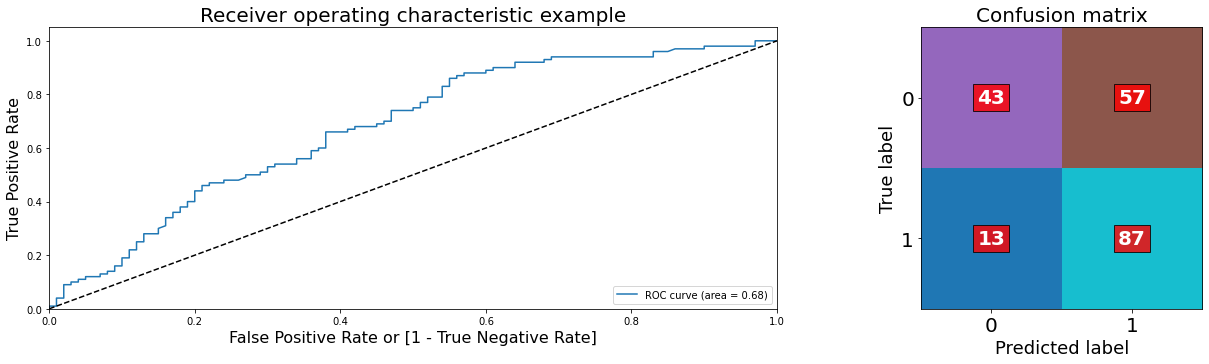

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.68  Threshold:0.49668
Accuracy 0.65 AUC: 0.68 Recall: 0.87 Precision: 0.6 F1: 0.71
Lexical_GBC


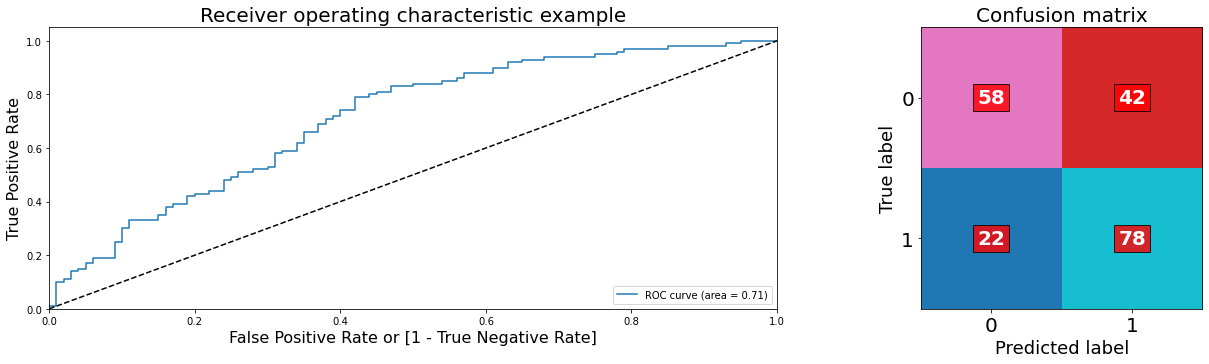

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.71  Threshold:0.45867
Accuracy 0.68 AUC: 0.71 Recall: 0.78 Precision: 0.65 F1: 0.71
Lexical_RFC


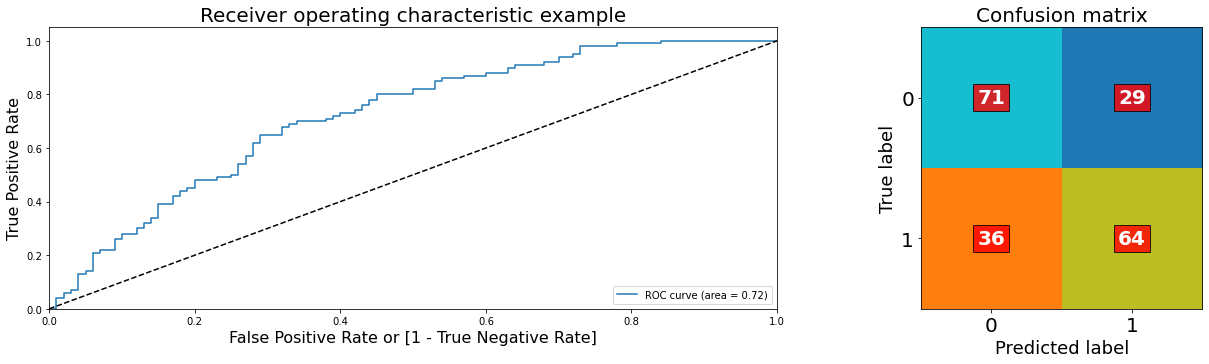

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.72  Threshold:0.55686
Accuracy 0.68 AUC: 0.72 Recall: 0.64 Precision: 0.69 F1: 0.66
[14:47:58] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Lexical_XGB


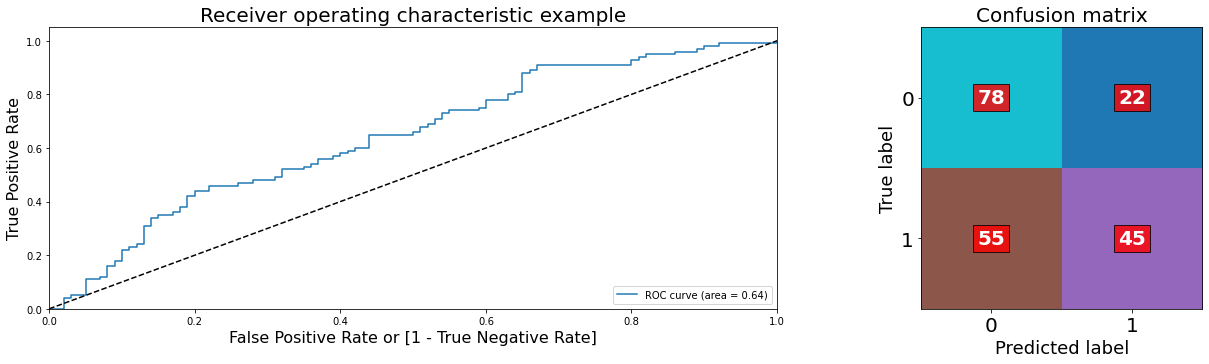

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.93273
Accuracy 0.62 AUC: 0.64 Recall: 0.45 Precision: 0.67 F1: 0.54
Lexical_DT


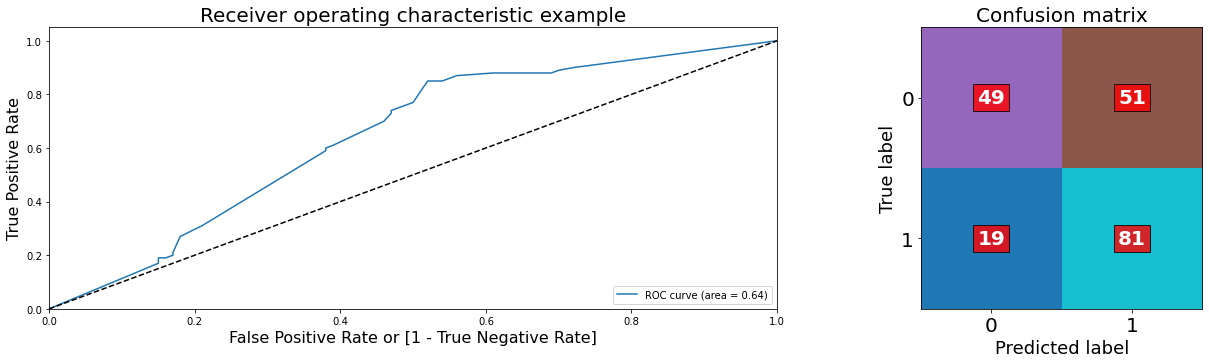

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.64  Threshold:0.38710
Accuracy 0.65 AUC: 0.64 Recall: 0.81 Precision: 0.61 F1: 0.7
Lexical_Perceptron


D:\Users\admin\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


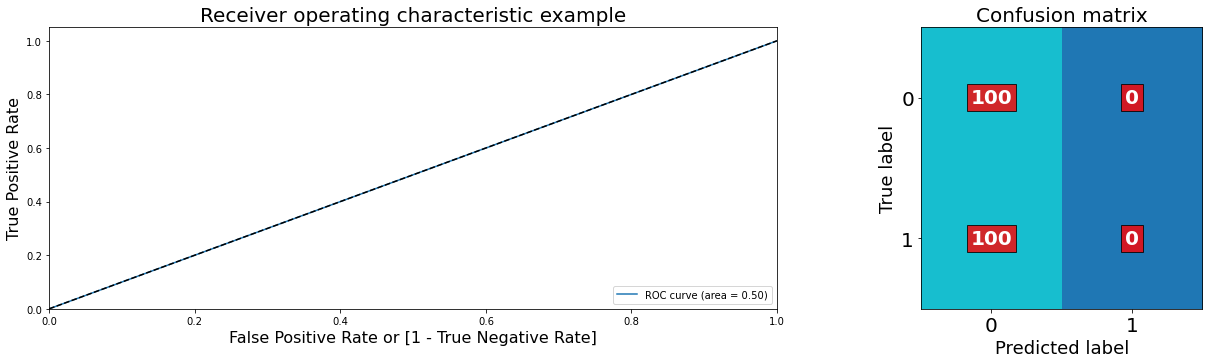

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.5  Threshold:1.00000
Accuracy 0.5 AUC: 0.5 Recall: 0.0 Precision: 0.0 F1: 0.0


In [9]:
#There are 9 embedding

embed_number=1
while embed_number<=9:
    X_train,X_val, y_train, y_val = read_embedding_data(embed_number)
    process_model_LR  ( embed_name[embed_number]+'_LR')   #1
    process_model_LGBM( embed_name[embed_number]+'_LGBM') #2
    process_model_NB  ( embed_name[embed_number]+'_NB')   #3
    process_model_SVC( embed_name[embed_number]+'_SVC')   #4
    process_model_ADB( embed_name[embed_number]+'_ADB')   #5
    process_model_GBC( embed_name[embed_number]+'_GBC')   #6
    process_model_RFC( embed_name[embed_number]+'_RFC')   #7
    process_model_XGB( embed_name[embed_number]+'_XGB')   #8
    process_mode_DT  ( embed_name[embed_number]+'_DT')    #9
    process_model_Perceptron(embed_name[embed_number]+'_Perceptron') #10
    embed_number+=1

#We 90 models = 9 embedding x 10 Classifier

## Save all predictions into a dataframe

In [10]:
df_prediction = pd.DataFrame(prediction)
df_prediction = df_prediction.set_index(X_val.index)

df_prediction.to_csv(resultsfolder + r'\model_predictions_'+model_with_data_list[option]+'.csv')
print ("File Name: "+ resultsfolder + r'\model_predictions_'+model_with_data_list[option]+'.csv')

File Name: D:\18-DS\github\SDSHL\data\results\model_predictions_Normal.csv


In [11]:
print("Total Models Created : {}".format(df_prediction.shape[1]) )

Total Models Created : 90


In [12]:
print(df_prediction.shape)

df_prediction.head(2)

(200, 90)


TFIDF_LR  TFIDF_LGBM  TFIDF_NB  TFIDF_SVC  TFIDF_ADB  TFIDF_GBC  \
ID                                                                      
5212  0.505911    0.614799  0.652971   0.622876   0.510990   0.395674   
8028  0.502537    0.413869  0.214869   0.492556   0.505086   0.640323   

      TFIDF_RFC  TFIDF_XGB  TFIDF_DT  TFIDF_Perceptron  Word2Vec_LR  \
ID                                                                    
5212   0.496548   0.919100  0.586957                 0     0.531258   
8028   0.493589   0.667191  0.586957                 0     0.530993   

      Word2Vec_LGBM  Word2Vec_NB  Word2Vec_SVC  Word2Vec_ADB  Word2Vec_GBC  \
ID                                                                           
5212       0.539438     0.976723      0.521155      0.503461      0.567279   
8028       0.651577     0.983616      0.618860      0.499118      0.544551   

      Word2Vec_RFC  Word2Vec_XGB  Word2Vec_DT  Word2Vec_Perceptron    BOW_LR  \
ID                                                                             
5212      0.625745      0.232757     0.500000                    0  0.544921   
8028      0.632099      0.814476     0.585774                    1  0.586848   

      BOW_LGBM    BOW_NB   BOW_SVC   BOW_ADB   BOW_GBC   BOW_RFC   BOW_XGB  \
ID                                                                           
5212  0.739255  0.990869  0.612044  0.505782  0.620893  0.540900  0.986764   
8028  0.680411  0.999839  0.553138  0.513691  0.506363  0.542574  0.967496   

        BOW_DT  BOW_Perceptron  IndicBERT_LR  IndicBERT_LGBM  IndicBERT_NB  \
ID                                                                           
5212  0.508772               1      0.500628        0.238524           1.0   
8028  0.000000               0      0.501203        0.331472           1.0   

      IndicBERT_SVC  IndicBERT_ADB  IndicBERT_GBC  IndicBERT_RFC  \
ID                                                                 
5212       0.548480       0.498499       0.479713       0.541513   
8028       0.579027       0.491741       0.350213       0.532863   

      IndicBERT_XGB  IndicBERT_DT  IndicBERT_Perceptron  mBERT_LR  mBERT_LGBM  \
ID                                                                              
5212       0.291576      0.347368                     0  0.505124    0.927944   
8028       0.119504      0.735294                     1  0.647620    0.301592   

          mBERT_NB  mBERT_SVC  mBERT_ADB  mBERT_GBC  mBERT_RFC  mBERT_XGB  \
ID                                                                          
5212  2.901606e-14   0.581403   0.508560   0.761425   0.752218   0.998698   
8028  1.000000e+00   0.668934   0.506942   0.344724   0.441907   0.099223   

      mBERT_DT  mBERT_Perceptron  fastText_LR  fastText_LGBM  fastText_NB  \
ID                                                                          
5212  0.588933                 0     0.554082       0.686638     0.988352   
8028  0.474394                 0     0.545570       0.177759     0.991751   

      fastText_SVC  fastText_ADB  fastText_GBC  fastText_RFC  fastText_XGB  \
ID                                                                           
5212      0.529781      0.505090      0.632250      0.634465      0.970229   
8028      0.621671      0.499435      0.524729      0.608250      0.043904   

      fastText_DT  fastText_Perceptron  IndicFT_LR  IndicFT_LGBM  \
ID                                                                 
5212     0.677741                    1    0.492490      0.002263   
8028     0.677741                    1    0.507307      0.996882   

        IndicFT_NB  IndicFT_SVC  IndicFT_ADB  IndicFT_GBC  IndicFT_RFC  \
ID                                                                       
5212  1.193907e-58     0.011538     0.425218     0.024439     0.073804   
8028  1.000000e+00     0.732040     0.522187     0.912608     0.829607   

      IndicFT_XGB  IndicFT_DT  IndicFT_Perceptron  fastTextWiki_LR  \

# Combine Features : Best Embedding + Lexical Features

In [19]:
embed_number=10
embed_name[10]='Combined'
embed_file['Combined']=r'\embedding_combined.csv'

In [15]:
#Lexical features
file_FE    = datafolder_p + r'\4-Hinglish_Sarcasm_Clean_FE.csv'

# This embedding produce best results. Best results are with GBC classifer
file_best_embedding = datafolder_p + '\embedding_ft300_wiki_pretrained.csv' 

dfBestembedding = pd.read_csv(file_best_embedding, index_col="ID")
dfBestembedding = dfBestembedding.drop(columns = ['label'])

df = pd.read_csv(file_FE, index_col='ID')
df_combined = pd.concat( [dfBestembedding, df], axis=1, ignore_index=False)

df_combined.to_csv(datafolder_p+ r'\embedding_combined.csv')

Combined
(1800, 320) (200, 320) (1800,) (200,)
Oversampling Technique Used:Normal
(1800, 320) (200, 320) (1800,) (200,)
Combined_LR


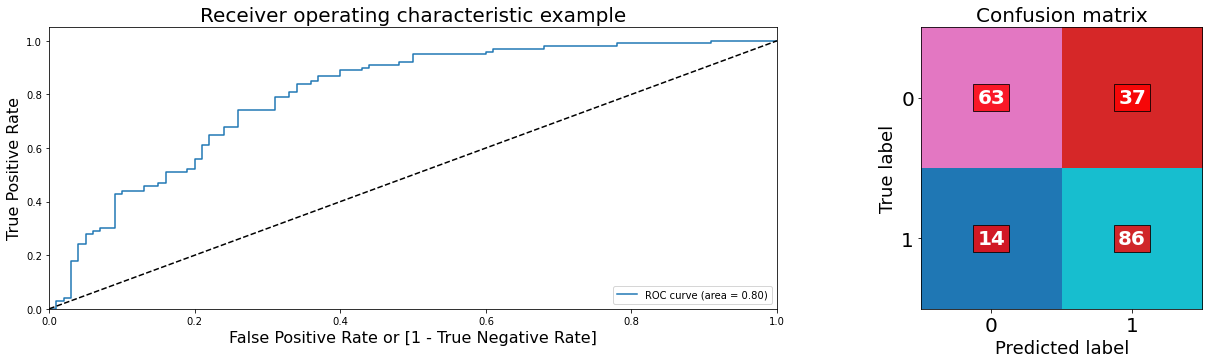

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.43265
Accuracy 0.74 AUC: 0.8 Recall: 0.86 Precision: 0.7 F1: 0.77
Combined_LGBM


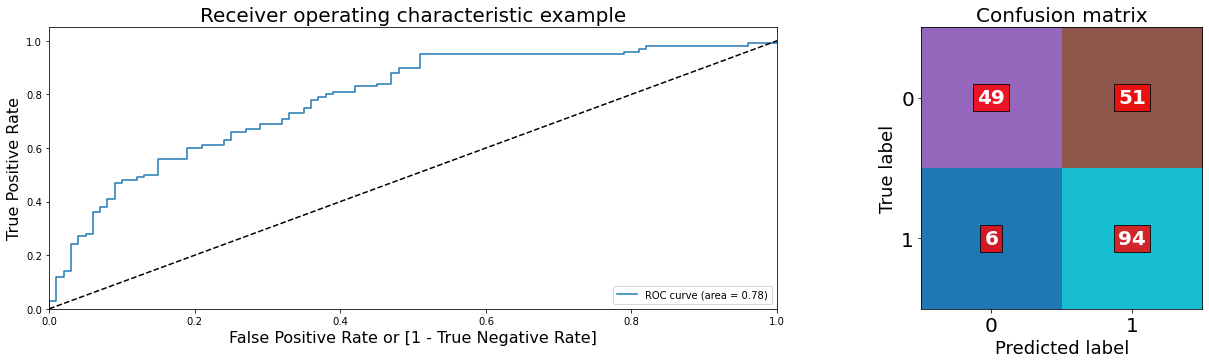

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.01640
Accuracy 0.72 AUC: 0.78 Recall: 0.94 Precision: 0.65 F1: 0.77
Combined_NB


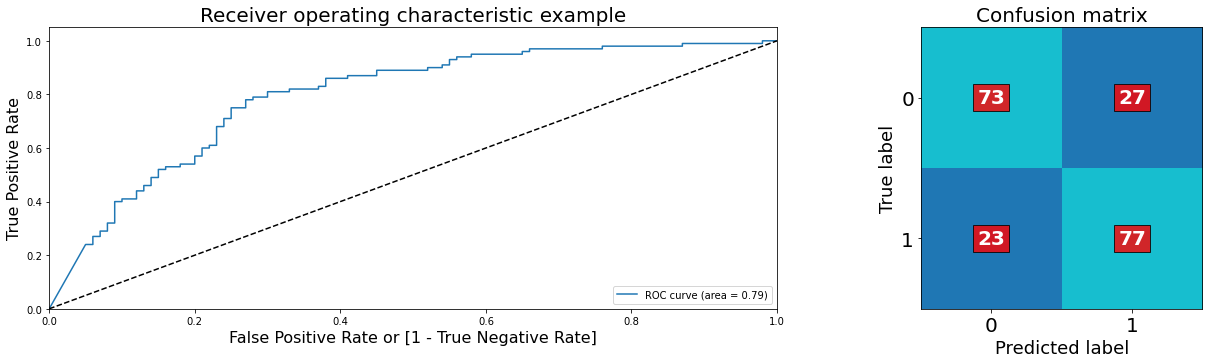

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.79  Threshold:0.36053
Accuracy 0.75 AUC: 0.79 Recall: 0.77 Precision: 0.74 F1: 0.75
Combined_SVC


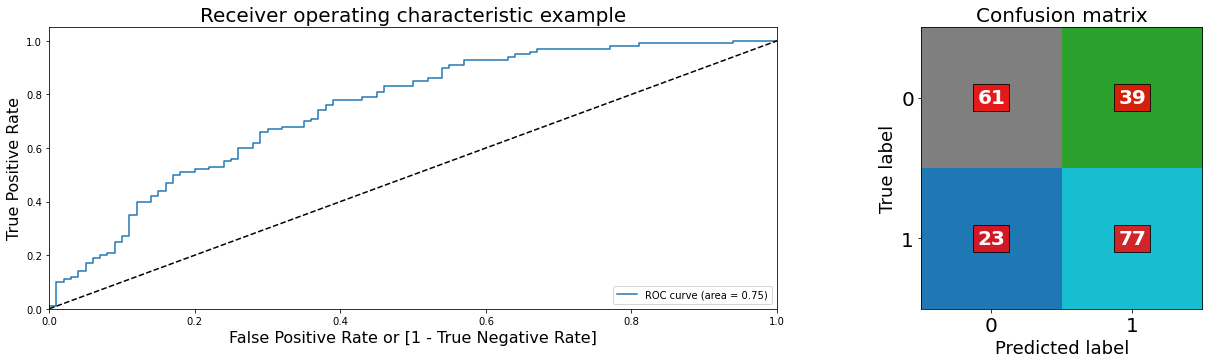

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.75  Threshold:0.45029
Accuracy 0.69 AUC: 0.75 Recall: 0.77 Precision: 0.66 F1: 0.71
Combined_ADB


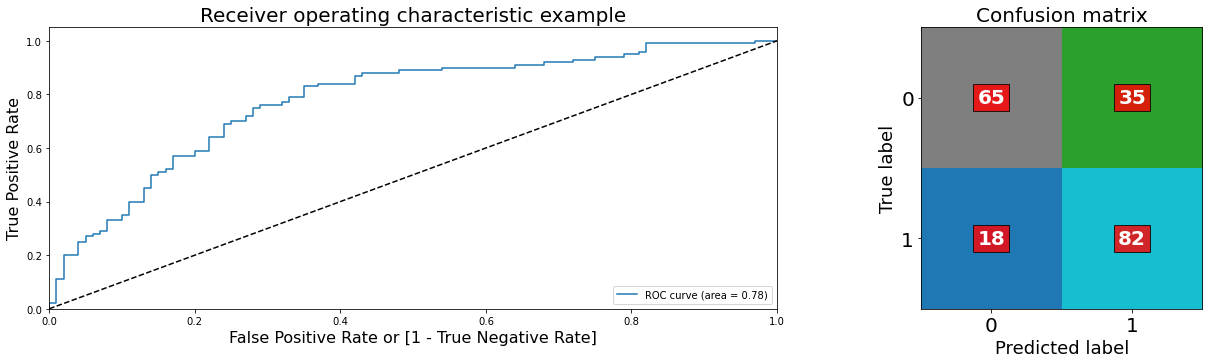

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.48682
Accuracy 0.74 AUC: 0.78 Recall: 0.82 Precision: 0.7 F1: 0.76
Combined_GBC


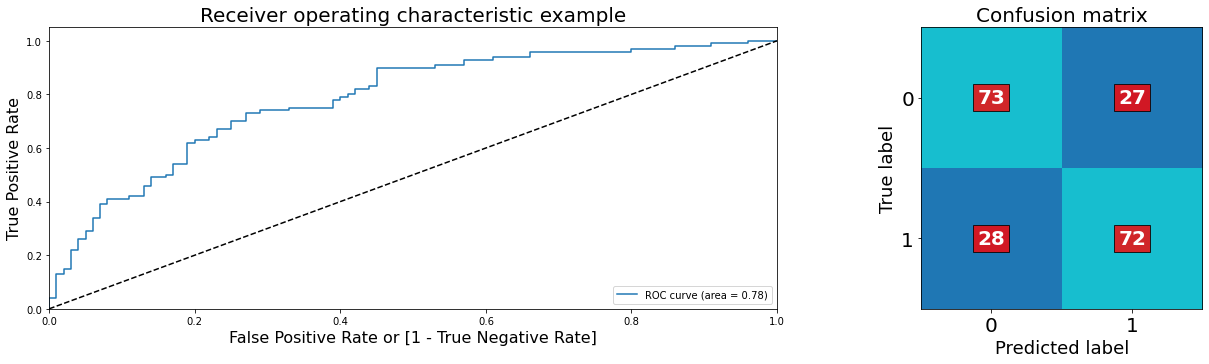

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.78  Threshold:0.39515
Accuracy 0.72 AUC: 0.78 Recall: 0.72 Precision: 0.73 F1: 0.72
Combined_RFC


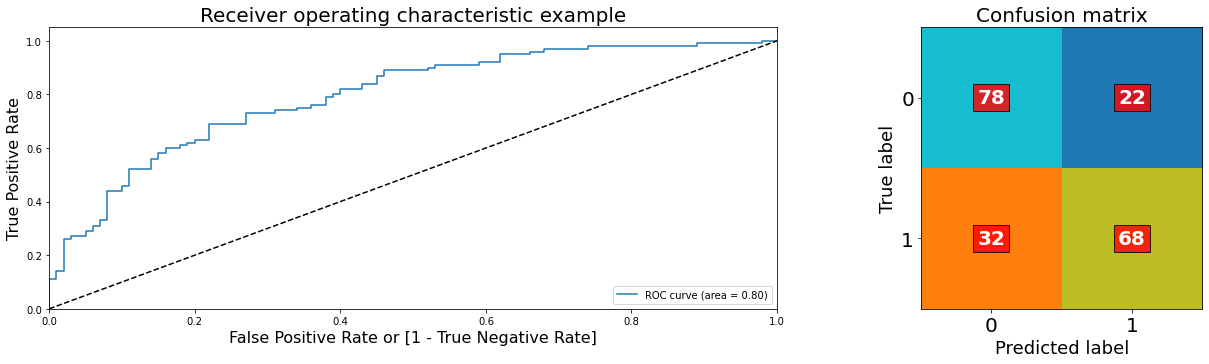

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.48038
Accuracy 0.73 AUC: 0.8 Recall: 0.68 Precision: 0.76 F1: 0.72
[15:00:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_level, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Combined_XGB


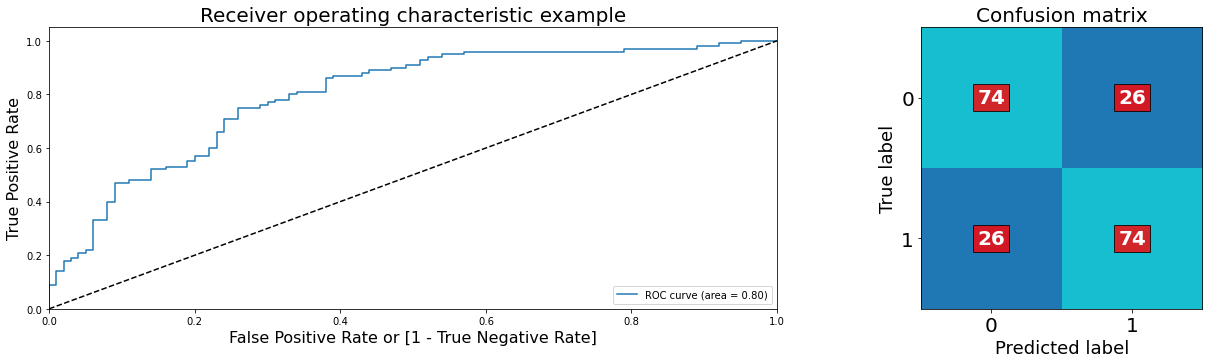

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.8  Threshold:0.21239
Accuracy 0.74 AUC: 0.8 Recall: 0.74 Precision: 0.74 F1: 0.74
Combined_DT


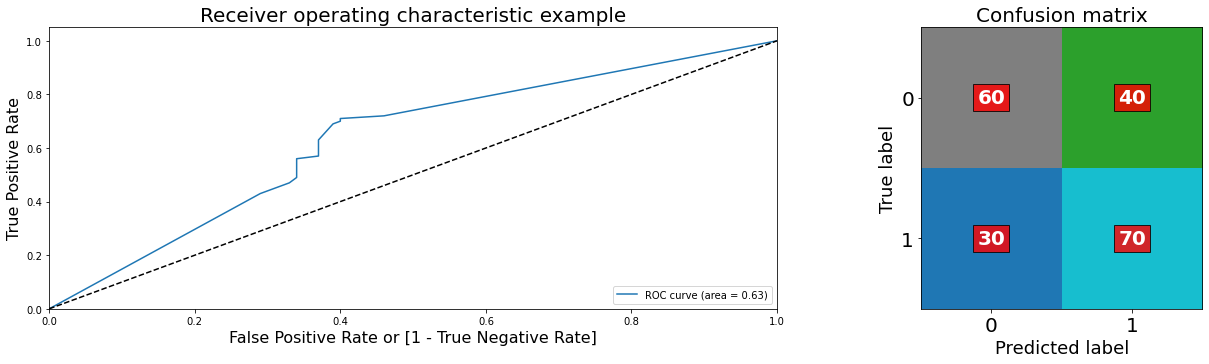

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.63  Threshold:0.16667
Accuracy 0.65 AUC: 0.63 Recall: 0.7 Precision: 0.64 F1: 0.67
Combined_Perceptron


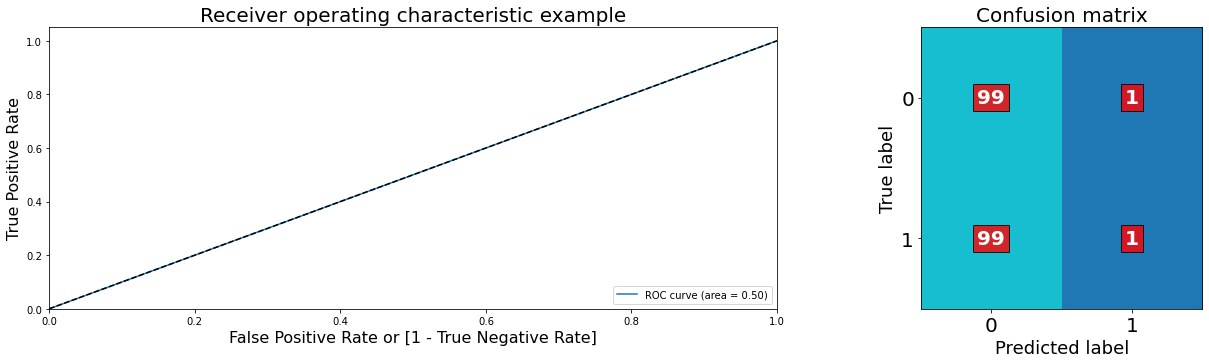

This Model Result is for  Normal  Data
ROC AUC Score on Test: 0.5  Threshold:2.00000
Accuracy 0.5 AUC: 0.5 Recall: 0.01 Precision: 0.5 F1: 0.02


In [20]:
X_train,X_val, y_train, y_val = read_embedding_data(embed_number)
process_model_LR  ( embed_name[embed_number]+'_LR')
process_model_LGBM( embed_name[embed_number]+'_LGBM')
process_model_NB  ( embed_name[embed_number]+'_NB')
process_model_SVC( embed_name[embed_number]+'_SVC')
process_model_ADB( embed_name[embed_number]+'_ADB')
process_model_GBC( embed_name[embed_number]+'_GBC')
process_model_RFC( embed_name[embed_number]+'_RFC')
process_model_XGB( embed_name[embed_number]+'_XGB')
process_mode_DT  ( embed_name[embed_number]+'_DT')
process_model_Perceptron(embed_name[embed_number]+'_Perceptron')
embed_number+=1

In [21]:
len(prediction)

100

In [22]:
df_prediction = pd.DataFrame(prediction)
df_prediction = df_prediction.set_index(X_val.index)

df_prediction.to_csv(resultsfolder + r'\model_predictions_combined.csv')
print ("File Name: "+ resultsfolder + r'\model_predictions_combined.csv')

File Name: D:\18-DS\github\SDSHL\data\results\model_predictions_combined.csv
